In [2]:
# make the code as Python 3 compatible as possible
from __future__ import print_function, division
import pypsa

import pandas as pd
import numpy as np
import geopy.distance
import glob
import numpy as np
import datetime
from sklearn_extra.cluster import KMedoids

# Printing
from pprint import *

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import cartopy.crs as ccrs

# Display options
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)



## Preprocessing: Calculate line distances based on lat/long coordinates
#df = pd.read_csv(r"C:\Users\Willem\pypsa-eur\data\minimal_example/buses.csv", sep = ";", encoding='latin-1')
#df = df.rename(columns = {df.columns[0] : 'name'})
#display(df)

#for index, row in df.iterrows():
#    coords1 = (row["x"],row["y"])
#    for index1, row1 in df.iterrows():
#        coords2 = (row1["x"],row1["y"])
#        dict_dist.update({str(row["name"]) + " and " + str(row1["name"]) : geopy.distance.distance(coords1, coords2).m})
#pprint(dict_dist)


In [3]:
#### PREPARATION OF DATA FOR IMPORTING TO NETWORK 

# bring excel sheets to correct separator format
path = r"C:\Users\Willem\pypsa-eur\data\minimal_example\*.csv"
target_path = r"C:\Users\Willem\pypsa-eur\data\minimal_example\input"
csv_folder_name = r"C:\Users\Willem\pypsa-eur\data\minimal_example\input_lopf"


for fname in glob.glob(path):
    print(fname)
    df_input = pd.read_csv(fname, sep = ";", encoding='latin-1')
    ftarget = fname.split("\\")[-1]
    print(type(ftarget))
    df_input.to_csv(path_or_buf = target_path + "\\" + ftarget, sep= ",")
    

C:\Users\Willem\pypsa-eur\data\minimal_example\buses.csv
<class 'str'>
C:\Users\Willem\pypsa-eur\data\minimal_example\carriers.csv
<class 'str'>
C:\Users\Willem\pypsa-eur\data\minimal_example\generators.csv
<class 'str'>
C:\Users\Willem\pypsa-eur\data\minimal_example\lines.csv
<class 'str'>
C:\Users\Willem\pypsa-eur\data\minimal_example\loads.csv
<class 'str'>


In [4]:
#### DEFINE HELPER FUNCTIONS FOR BUILDING NETWORK

# Define helper functions for lopf

def my_f(network,snapshots):
    print(snapshots)
    
def print_lopf_insights(network):
    # generator power
    print(" \nGenerator active power per snapshot:")
    print(network.generators_t.p)

    # network line flows
    print(" \nLine active power per snapshot:")
    print(network.lines_t.p0)
    
    # relative line loading
    print(" \nRelative line loading per snapshot:")
    print(abs(network.lines_t.p0)/network.lines.s_nom)
    max_loading = (network.lines_t.p0/network.lines.s_nom).max(axis = 0)
    print(max_loading)

    #In linear approximation, all voltage magnitudes are nominal, i.e. 1 per unit
    print(" \nVoltage magnitude at nodes:")
    print(network.buses_t.v_mag_pu)

    #At bus 2 the price is set above any marginal generation costs in the model, because to dispatch to
    #it from expensive generator 0, also some dispatch from cheap generator 1 has to be substituted from generator0
    #to avoid overloading line 1.
    print(" \nMarginal prices at nodes:")
    print(network.buses_t.marginal_price)
    
# Define builder functions
    
def create_snapshots(T,w,s,network):
    '''
    Creates snapshots for T hours with weighting w (each snapshot representing w hours) 
    starting at hour s.
    '''
    # Create starting hour
    starting_hour = datetime.datetime(2019,1,1) + datetime.timedelta(hours=s) 
    network.set_snapshots(pd.to_datetime([starting_hour + datetime.timedelta(hours=i) for i in range(T)]))
    network.snapshot_weightings = pd.Series(w,index=network.snapshots)
    display(network.snapshots)
    
    
def add_energy_carriers(network):
    network.add("Carrier","gas",co2_emissions=0.24)
    network.add("Carrier","wind",co2_emissions=0.0)
    network.add("Carrier","battery",co2_emissions=0.0)
    network.add("Carrier","hydro",co2_emissions=0.0)
    network.add("Carrier","lignite",co2_emissions=0.)
    network.add("Carrier","hard coal",co2_emissions=0.0)
    network.add("Carrier","oil",co2_emissions=0.0)
    network.add("Carrier","nuclear",co2_emissions=0.0)
    network.add("Carrier","solar",co2_emissions=0.0)

    
def add_buses(network, csv_folder):
    '''
    Adds the predefined buses to the model
    '''
    buses_imp = pd.read_csv(csv_folder + '/buses.csv')
    buses_imp.drop(columns = buses_imp.columns[0], inplace = True)
    buses = buses_imp.copy().rename(columns = {buses_imp.columns[0] : 'attribute'})
    buses.set_index(["attribute"], inplace = True)
    network.import_components_from_dataframe(buses, "Bus")
    
    
def add_lines(network, csv_folder):
    '''
    Adds the predefined lines to the model.
    Make the nw -> sw line capacity NON-EXTENDABLE -> constrained line
    '''    
    lines = (pd.read_csv(csv_folder + '/lines.csv'))
    lines.drop(columns = lines.columns[0], inplace = True)
    lines = lines.copy().rename(columns = {lines.columns[0] : 'attribute'})
    lines.set_index(["attribute"], inplace = True)
    network.import_components_from_dataframe(lines, "Line")
    
    # constrained line (non extendable s_nom)
    network.lines.at["line_n_s_1","s_nom"] = 1000
    network.lines.at["line_n_s_1","s_nom_extendable"] = False
    
    
def add_generators(network, csv_folder):
    '''
    Adds predefined conventional generators.
    Adds renewable generators.
    '''
    generators = pd.read_csv(csv_folder + '/generators.csv').iloc[:, 0:6]
    generators.drop(columns = generators.columns[0], inplace = True)
    generators = generators.copy().rename(columns = {generators.columns[0] : 'attribute'})
    generators.set_index(["attribute"], inplace = True)
    network.import_components_from_dataframe(generators, "Generator")
    # Wind generators
    network.add("Generator", "Wind_1", 
                carrier = "wind", 
                bus = "bus_1_nw",
                p_nom = 170,
                efficiency = 0.78,  
                marginal_cost = 0 + 0.01, # non zero marginal cost to ensure unique optimization result
                capital_cost = 0,
                p_nom_extendable = True,
                p_nom_min = 100,
                p_nom_max = 300,
               )
    network.add("Generator", "Wind_2", 
                carrier = "wind", 
                bus = "bus_1_nw",
                p_nom = 170,
                efficiency = 0.78,  
                marginal_cost = 0 + 0.01, # non zero marginal cost to ensure unique optimization result
                capital_cost = 0,
                p_nom_extendable = True,
                p_nom_min = 100,
                p_nom_max = 300,
               )
    network.add("Generator", "Wind_3", 
                carrier = "wind", 
                bus = "bus_1_nw",
                p_nom = 170,
                efficiency = 0.78,  
                marginal_cost = 0 + 0.01, # non zero marginal cost to ensure unique optimization result
                capital_cost = 0,
                p_nom_extendable = True,
                p_nom_min = 100,
                p_nom_max = 300,
               )
    # PV generator
    network.add("Generator", "PV_1", 
                carrier = "solar", 
                bus = "bus_3_sw",
                p_nom = 10,
                efficiency = 0.99,
                marginal_cost = 0 + 0.01, # non zero marginal cost to ensure unique optimization result
                capital_cost = 0,
                p_nom_extendable = True,
                p_nom_max = 300,
                p_nom_min=0
               )
    
    
def add_loads(network): 
    '''
    Adds static loads to the network
    Removes previously added loads from network
    '''
    network.mremove("Load", [name for name in network.loads.index.tolist()])
    load_dict = {"load_1_ne": ("bus_2_ne", 500), 
                 "load_2_sw": ("bus_3_sw", 2000), 
                 "load_3_se": ("bus_4_se", 1000)}
    for load in load_dict:
        network.add("Load", 
                    name = load, 
                    bus = load_dict[load][0],
                    p_set = load_dict[load][1],
                    sign = -1
                   )

              
def add_time_series(network,T,w,s):
    '''
    Creates time series for load, wind generation and solar generation by scaling the scalar nominal power 
    with relative generation time series for germany (relative to mean generation of each technology):
    - time series for loads
    - time series for wind generation
    - time series for pv generation
    '''
    # Import load and generation data for germany
    df_ger = pd.read_csv(r"C:\Users\Willem\pypsa-eur\data\Redispatch\opsd-time_series-2020-10-06/time_series_60min_singleindex.csv")
    cols_ger = list(df_ger.loc[:,"DE_load_actual_entsoe_transparency":'DE_transnetbw_wind_onshore_generation_actual'])
    cols_ger.append("cet_cest_timestamp")
    cols_ger = [cols_ger[-1]] + cols_ger[:-1]
    df_ger = df_ger.loc[:,cols_ger]
    
    # change index to datetime object
    df_ger[["Date","Time"]] = df_ger["cet_cest_timestamp"].str.split(pat = "T", expand = True)
    df_ger[["Time","xxxx"]] = df_ger["Time"].str.split(pat = "+", expand = True)
    df_ger = df_ger.drop(["xxxx","cet_cest_timestamp"],axis = 1)
    df_ger["name"] = pd.to_datetime(df_ger['Date'] + ' ' + df_ger['Time'])
    df_ger = df_ger.drop(["Date","Time"], axis = 1).set_index("name", drop = True)
    df_ger = df_ger.loc["2019-01-01 00:00:00":"2019-12-31 23:00:00", :]
    #df_ger = df_ger[~df_ger.index.duplicated(keep='first')]
    df_ger.reset_index(inplace = True, drop = True)
    
    # Generate relative columns to get the load profile
    s_loads = df_ger["DE_load_actual_entsoe_transparency"].divide(df_ger["DE_load_actual_entsoe_transparency"].mean())
    s_wind  = df_ger["DE_wind_generation_actual"].divide(df_ger["DE_wind_generation_actual"].mean())
    s_solar = df_ger["DE_solar_generation_actual"].divide(df_ger["DE_solar_generation_actual"].mean())
    
    #### Time series to dicts
    # Create empty dicts
    dict_loads = {}
    dict_wind = {}
    dict_solar = {}
    # load time series
    for load in network.loads.index:
        dict_loads[load] = s_loads * network.loads.p_set[load] 
    # wind time series
    wind_generators = network.generators[network.generators.carrier == "wind"]
    for wind in wind_generators.index:
        dict_wind[wind] = s_wind
    # Solar time series
    solar_generators = network.generators[network.generators.carrier == "solar"]
    for solar in solar_generators.index:
        dict_solar[solar] = s_solar
        
    #### Dicts to dataframes
    df_loads = pd.DataFrame.from_dict(dict_loads, orient = "columns")
    df_wind = pd.DataFrame.from_dict(dict_wind, orient = "columns")
    df_solar = pd.DataFrame.from_dict(dict_solar, orient = "columns")
    
    # Slice dataframes according to the snapshots (24h slices)
    df_loads_network = df_loads.loc[s:(s+T-1)]
    df_wind_network = df_wind.loc[s:(s+T-1)]
    df_solar_network = df_solar.loc[s:(s+T-1)]
    display(df_loads_network)
    
    # load time series
    network.loads_t.p_set = pd.DataFrame(index = network.snapshots, columns = network.loads.index, data = df_loads_network.to_numpy(copy = True))
    # Wind time series
    network.generators_t.p_max_pu = network.generators_t.p_max_pu.reindex(columns=wind_generators.index)
    network.generators_t.p_max_pu.loc[:,wind_generators.index] = pd.DataFrame(index = network.snapshots,
                                                                              columns = wind_generators.index,
                                                                              data = df_wind_network.to_numpy(copy= True))
    # Solar time series
    network.generators_t.p_max_pu.loc[:,solar_generators.index] = pd.DataFrame(index = network.snapshots,
                                                                              columns = solar_generators.index,
                                                                              data = df_solar_network.to_numpy(copy= True))
    
def build_base_network(T, w, s, network, csv_folder, csv_folder_lopf):
    '''
    Uses predefined component building functions for building initial example grid without hydro and battery storage
    -----
    Parameters:
    T: Number of snapshots
    w: weighting of snapshots
    s: starting hour of the modelling
    network: network to add the variables and components to
    csv_folder: Folder to import netowork data from
    csv_folder_lopf: Folder to export the network to
    '''
    create_snapshots(T, w, s, network)
    add_energy_carriers(network)
    add_buses(network, csv_folder)
    add_lines(network, csv_folder)
    add_generators(network, csv_folder)
    add_loads(network)
    add_time_series(network,T,w,s)
    network.name = "Base network"

        
def add_storage_units(network):
    '''
    Adds all non-battery storage units to the base network
    Removes previously added storage units from the network
    '''
    network.mremove("StorageUnit", [name for name in network.storage_units.index.tolist()])
    network.add("StorageUnit", name = "PHES_1",
                bus = "bus_4_se",
                control = "PQ",
                p_nom = 150,
                marginal_cost = 20,
                capital_cost = 0,
                p_nom_extendable = True,
                p_max_pu = 1,
                p_min_pu = -1,
                efficiency_store = 0.86,
                efficiency_dispatch = 0.89,
                state_of_charge_initial = 0.0,
                max_hours = 1000,
                standing_loss = 0.01,
                inflow = 0.02 
               )


In [5]:
# -------------
# Functions from the pypsa-eur analysis
# -------------

# Create operative network
def set_parameters_from_optimized(n, n_optim):
    '''
    Function to set optimized parameters from optimized network as nominal parameters of the operative network.
    -----
    Param:
    n: Optimized investment network.
    n_optim: Operative network for redispatch simulation.
    '''
    
    # set line capacities to optimized
    lines_typed_i = n.lines.index[n.lines.type != '']
    n.lines.loc[lines_typed_i, 'num_parallel'] = \
        n_optim.lines['num_parallel'].reindex(lines_typed_i, fill_value=0.)
    n.lines.loc[lines_typed_i, 's_nom'] = (
        np.sqrt(3) * n.lines['type'].map(n.line_types.i_nom) *
        n.lines.bus0.map(n.buses.v_nom) * n.lines.num_parallel)
    
    lines_untyped_i = n.lines.index[n.lines.type == '']
    for attr in ('s_nom', 'r', 'x'):
        n.lines.loc[lines_untyped_i, attr] = \
            n_optim.lines[attr].reindex(lines_untyped_i, fill_value=0.)
    n.lines['s_nom_extendable'] = False
    
    # set link capacities to optimized (HVDC links as well as store out/inflow links)
    links_dc_i = n.links.index[n.links.carrier == 'DC']
    n.links.loc[links_dc_i, 'p_nom'] = \
        n_optim.links['p_nom_opt'].reindex(links_dc_i, fill_value=0.)
    n.links.loc[links_dc_i, 'p_nom_extendable'] = False
    
    # set extendable generators to optimized and p_nom_extendable to False
    gen_extend_i = n.generators.index[n.generators.p_nom_extendable]
    n.generators.loc[gen_extend_i, 'p_nom'] = \
        n_optim.generators['p_nom_opt'].reindex(gen_extend_i, fill_value=0.)
    n.generators.loc[gen_extend_i, 'p_nom_extendable'] = False
    
    # set extendable storage unit power to ooptimized
    stor_extend_i = n.storage_units.index[n.storage_units.p_nom_extendable]
    n.storage_units.loc[stor_extend_i, 'p_nom'] = \
        n_optim.storage_units['p_nom_opt'].reindex(stor_extend_i, fill_value=0.)
    n.storage_units.loc[stor_extend_i, 'p_nom_extendable'] = False

    return n

def print_lopf_insights(network):
    # generator power
    print(" \nGenerator active power per snapshot:")
    print(network.generators_t.p)

    # network line flows
    print(" \nLine active power per snapshot:")
    print(network.lines_t.p0)
    
    # relative line loading
    print(" \nRelative line loading per snapshot:")
    print(abs(network.lines_t.p0)/network.lines.s_nom)
    max_loading = (network.lines_t.p0/network.lines.s_nom).max(axis = 0)
    print(max_loading)

    #In linear approximation, all voltage magnitudes are nominal, i.e. 1 per unit
    print(" \nVoltage magnitude at nodes:")
    print(network.buses_t.v_mag_pu)

    #At bus 2 the price is set above any marginal generation costs in the model, because to dispatch to
    #it from expensive generator 0, also some dispatch from cheap generator 1 has to be substituted from generator0
    #to avoid overloading line 1.
    print(" \nMarginal prices at nodes:")
    print(network.buses_t.marginal_price)


def clean_batteries(network):
    """
    Clean up all previously saved battery components (FROM PYPSA-EUR) related to redispatch (does NOT delete the inital batteries)
    """
    
    network.mremove("StorageUnit", [name for name in network.storage_units.index.tolist() 
                                    if network.storage_units.loc[name]["carrier"] == "battery"])
    
    network.mremove("Link", [name for name in network.links.index.tolist()
                             if "BESS" in name])
    
    network.mremove("Store", [name for name in network.stores.index.tolist()
                             if "BESS" in name])
    
    network.mremove("Bus", [name for name in network.buses.index.tolist()
                           if "BESS" in name])

    
def add_BESS_loadflexibility(network, network_year, flex_potential = 10000, c_rate = 0.25, flex_share = 0.1):
    '''
    Adds battery storages at every node, depending on the flexibility potential of the loads allocated to this node. 
    Methodology according to Network development plan and Frontier study:
        - Flexibility potential at load-nodes: Flexibility Potential through stationary battery storage in distribution grids
        - Flexibility potential at power plants: Flexibility through battery installations at powerplants (by operators)
    
    Following the assumption of x percentage of frontier flexibility potential being installed at node according to loads. 
    Flexibility potential can e.g. be aggregated powerwall capacity at the node.
    -----
    Param:
    network: network from dispatch optimization 
    network_year: full time resolution network (typically 1 year)
    flex_potential: Total flexibility potential from distribution grid (default: frontier-study potential)
    '''
    # Clean up all previously saved battery components
    clean_batteries(network)
    
    # get bus names
    bus_names = network.buses.index.tolist()
    
    # get mean load at every bus
    df_loads = network_year.loads
    df_loads["p_mean"] = network_year.loads_t.p_set.mean(axis = 0)
    
    # According to x% rule, add energy stores with energy = x% of average load at bus
    for i in range(len(bus_names)):
        bus_name = network.buses.index.tolist()[i]
        battery_bus = "{}_{}".format(bus_name,"BESS")
        
        # determin flexibility at bus
        df_loads_bus = df_loads[df_loads["bus"] == bus_name]
        
        ################
        
        
        # TODO: ÄNDERN DER maximalen energie: Die speicherbare energie soll abhängig vom mittelwert der last 
        # über den GESAMTEN zeitraum sein, nicht nur vom mittelwert des aktuellen (1 day) networks!
        
        
        ################
        
        if not df_loads_bus.empty:
            p_flex = df_loads_bus.p_mean * flex_share
        else:
            p_flex = 0
            
        print("p_flex = " + str(p_flex))

        # add additional bus solely for representation of battery at location of previous bus
        network.add("Bus",
                    name = battery_bus,
                    x = network.buses.loc[bus_name,"x"],
                    y = network.buses.loc[bus_name,"y"],
                    carrier = "battery")
        # add store
        network.add("Store", name = "BESS_{}".format(i),
                    bus = battery_bus,
                    e_nom = p_flex / c_rate,
                    e_nom_extendable = False,
                    e_min_pu = 0,
                    e_max_pu = 1,
                    e_initial = 0.5,
                    e_cyclic = True,
                    p_set = p_flex,
                    q_set = 0.05,
                    marginal_cost = 0,
                    capital_cost = 0,
                    standing_loss = 0)
        # discharge link
        network.add("Link",
                    name = "BESS_{}_discharger".format(i+1),
                    bus0 = battery_bus,
                    bus1 = bus_name,
                    capital_cost = 0,
                    p_nom = p_flex,
                    p_nom_extendable = False,
                    p_max_pu = 1,
                    p_min_pu = 0,
                    marginal_cost = 0,
                    efficiency = 0.96)
        # charge link
        network.add("Link",
                    name = "BESS_{}_charger".format(i+1),
                    bus0 = bus_name,
                    bus1 = battery_bus,
                    capital_cost = 0,
                    p_nom = p_flex,
                    p_nom_extendable = False,
                    p_max_pu = 1,
                    p_min_pu = 0,
                    marginal_cost = 0,
                    efficiency = 0.96)
    network.name = str(network.name) + " BESS loadflexibility"
        
def add_BESS(network):
    '''
    Adds static battery storages (fixed capacity) to the base network
    Removes previously added batteries (links and stores) from the network
    
    A battery is added to the network by combining a link for discharge, and one for charge (representing inverter operations)
    and a store unit representing the battery capacity
    '''
    # Clean up all previously saved battery components
    clean_batteries(network)
    
    bus_names = network.buses.index.tolist()
    for i in range(len(bus_names)):
        bus_name = bus_names[i]
        battery_bus = "{}_{}".format(bus_name,"BESS")
        # add additional bus solely for representation of battery at location of previous bus
        network.add("Bus",
                    name = battery_bus,
                    x = network.buses.loc[bus_name,"x"],
                    y = network.buses.loc[bus_name,"y"],
                    carrier = "battery")
        # discharge link
        network.add("Link",
                    name = "Battery_{}_dCH".format(i+1),
                    bus0 = battery_bus,
                    bus1 = bus_name,
                    capital_cost = 0,
                    p_nom = 150,
                    p_nom_extendable = False,
                    p_max_pu = 1,
                    p_min_pu = 0,
                    marginal_cost = 0,
                    efficiency = 0.96)
        # charge link
        network.add("Link",
                    name = "Battery_{}_CH".format(i+1),
                    bus0 = bus_name,
                    bus1 = battery_bus,
                    capital_cost = 0,
                    p_nom = 150,
                    p_nom_extendable = False,
                    p_max_pu = 1,
                    p_min_pu = 0,
                    marginal_cost = 0,
                    efficiency = 0.96)
        # add store
        network.add("Store", name = "BESS_{}".format(i),    
                    bus = battery_bus,
                    e_nom = 200,
                    e_nom_extendable = False,
                    e_min_pu = 0,
                    e_max_pu = 1,
                    e_initial = 0.5,
                    e_cyclic = True,
                    p_set = 100,
                    q_set = 0.05,
                    marginal_cost = 0,
                    capital_cost = 0,
                    standing_loss = 0)
    network.name = str(network.name) + " BESS"
    
        
def clean_generators(network):
    """
    Remove all generators from network
    """
    network.mremove("Generator", [name for name in network.generators.index.tolist()])


def build_redispatch_network(network, network_dispatch):
    '''
    Uses predefined component building functions for building the redispatch network.
    Passes the dispatch per generator as fixed generation for each generator.
    Adds a ramp down generator (neg. redispatch) and ramp up generator (pos. redispatch) for each conventional generator.
    Adds a ramp down generator (curtailment) for each EE generator.
    -----
    Parameters:
    network: network representing one day of snapshots (not optimized)
    network_dispatch: network from dispatch optimization (one node market model)
    '''
    # Copy initial network and remove generators for redispatch step
    network_redispatch = network.copy()
    clean_generators(network_redispatch)
    
    # Add new generators for redispatch calculation
    l_generators = network.generators.index.tolist()
    l_conv_carriers = ["hard coal","lignite","gas","oil","nuclear","OCGT","CCGT"]
    
    for generator in l_generators:
        
        # For each conventional generator in network: Add 3 generators in network_redispatch
        if network.generators.loc[generator]["carrier"] in l_conv_carriers:
            # Base generator from network, power range is fixed by dispatch simulation results (therefore runs at 0 cost)
            network_redispatch.add("Generator",
                                   name = "{}".format(generator), 
                                   bus = network.generators.loc[generator]["bus"],
                                   p_nom = network.generators.loc[generator]["p_nom"],
                                   efficiency = network.generators.loc[generator]["efficiency"],
                                   marginal_cost = 0,
                                   capital_cost = 0,
                                   p_max_pu = (network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   p_min_pu = (network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                  )
            # Upwards generator (positive redispatch) ranges within the difference of the base power p_max_pu (e.g. 0.92) and p_max_pu = 1
            network_redispatch.add("Generator",
                                   name = "{}_pos".format(generator), 
                                   bus = network.generators.loc[generator]["bus"],
                                   p_nom = network.generators.loc[generator]["p_nom"],
                                   efficiency = network.generators.loc[generator]["efficiency"],
                                   marginal_cost = network.generators.loc[generator]["marginal_cost"],
                                   capital_cost = 0,
                                   p_max_pu = (1 - network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   p_min_pu = 0,
                                  )
            # Downwards generator (negative redispatch): Using this generator reduces the energy feed in at specific bus, 
            # but increases costs for curtialment. Cost for curtailment = lost profit for not feeding in - savings through ramp down 
            network_redispatch.add("Generator",
                                   name = "{}_neg".format(generator), 
                                   bus = network.generators.loc[generator]["bus"],
                                   p_nom = network.generators.loc[generator]["p_nom"],
                                   efficiency = network.generators.loc[generator]["efficiency"],
                                   marginal_cost = (network.generators.loc[generator]["marginal_cost"] - network_dispatch.buses_t.marginal_price[network_dispatch.generators.loc[generator]["bus"]]).tolist(),
                                   capital_cost = 0,
                                   p_max_pu = 0,
                                   p_min_pu = (- network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                  )
            
        else:
            # For renewable sources: Only add base and negative generator, representing the curtailment of EE 
            network_redispatch.add("Generator",
                                   name = "{}".format(generator), 
                                   bus = network.generators.loc[generator]["bus"],
                                   p_nom = network.generators.loc[generator]["p_nom"],
                                   efficiency = network.generators.loc[generator]["efficiency"],
                                   marginal_cost = 0,
                                   capital_cost = 0,
                                   p_max_pu = (network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   p_min_pu = (network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                  )
            # Downwards generator (negative redispatch): Using this generator reduces the energy feed in at specific bus, 
            # but increases costs for curtialment. Cost for curtailment = lost profit for not feeding in - savings through ramp down 
            network_redispatch.add("Generator",
                                   name = "{}_neg".format(generator), 
                                   bus = network.generators.loc[generator]["bus"],
                                   p_nom = network.generators.loc[generator]["p_nom"],
                                   efficiency = network.generators.loc[generator]["efficiency"],
                                   marginal_cost = (network.generators.loc[generator]["marginal_cost"] - network_dispatch.buses_t.marginal_price[network_dispatch.generators.loc[generator]["bus"]]).tolist(),
                                   capital_cost = 0,
                                   p_max_pu = 0,
                                   p_min_pu = (- network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                  )
    network_redispatch.name = str(network_redispatch.name) + " redispatch"
    
    return network_redispatch


def build_market_model(network):
    '''
    Clusters all generators, loads, stores and storage units to a single (medoid) bus to emulate market simulation.

    TODO: For multiple countries, the dataset to be clusterd first needs to be separated by country (groupby("country")) and then clustered.
    '''   
    network_dispatch = network.copy()
    
    # cluster all buses to the center one and assign all grid elements to that bus
    df_busmap = network_dispatch.buses

    # Cluster buses to 1 cluster & compute center
    np_busmap = df_busmap[["x","y"]].to_numpy()

    # Compute cluster score
    k_medoids = KMedoids(n_clusters=1, metric='euclidean', init='k-medoids++', max_iter=300, random_state=None)
    score = k_medoids.fit(np_busmap)

    x_medoid = k_medoids.cluster_centers_[0][0]
    y_medoid = k_medoids.cluster_centers_[0][1]

    # find single medoid bus in dataframe
    market_bus = df_busmap[(df_busmap["x"] == x_medoid) & (df_busmap["y"] == y_medoid)]
    bus_name = str(market_bus.index.values)[2:-2] # save bus name, remove brackets & quotemarks

    # assign all generators, loads, storage_units, stores to the medoid bus (market_bus)
    network_dispatch.loads["bus"] = bus_name
    network_dispatch.generators["bus"] = bus_name
    network_dispatch.stores["bus"] = bus_name
    network_dispatch.storage_units["bus"] = bus_name
    return network_dispatch


def solve_redispatch_network(network, network_dispatch):
    '''
    Calls the building function and solves the network under redispatch constraints.
    -----
    Parameters:
    network: network from dispatch optimization
    '''
    #### TODO: add extra functionality that only pos OR negative can be =! 0 during 1 snapshot    

    network_redispatch = build_redispatch_network(network, network_dispatch)
    # Solve new network
    network_redispatch.lopf(solver_name="gurobi", 
                 formulation ="kirchhoff")
    
    #print_lopf_insights(network_redispatch)
    
    # Plot line loadings 
    series_loading  = ((network_redispatch.lines_t.p0.abs().mean().sort_index() / 
                        (network_redispatch.lines.s_nom_opt*network_redispatch.lines.s_max_pu)
                        .sort_index()).fillna(0.))

    fig,ax = plt.subplots(figsize = (10,10),subplot_kw = {"projection": ccrs.PlateCarree()})
    
    network_redispatch.plot(ax=ax,
           bus_colors ="gray",
           branch_components = ["Line"],
           line_widths = network_redispatch.lines.s_nom_opt/3e3,
           line_colors = series_loading,
           line_cmap=plt.cm.viridis,
           color_geomap = True,
           bus_sizes = 0,
           geomap = True)
    ax.axis("on")
    return network_redispatch
    
    
# Redispatch workflow with batteries
def build_redispatch_network_with_bat(network, network_dispatch, network_year, c_rate, flex_share, flex_store = True):
    '''
    Uses predefined component building functions for building the redispatch network and adds batteries.
    -----
    Parameters:
    network: network from dispatch optimization 
    '''
    network_redispatch_bat = build_redispatch_network(network, network_dispatch)
    # Adding a battery at every node
    if flex_store == True:
        add_BESS_loadflexibility(network_redispatch_bat, network_year, c_rate, flex_share)
    else:
        add_BESS(network_redispatch_bat)
        
    return network_redispatch_bat
    
def solve_redispatch_network_with_bat(network, network_dispatch, network_year, c_rate, flex_share,flex_store = True):
    '''
    Calls redispatch building function and solves the network.
    -----
    Parameters:
    network: network from dispatch optimization 
    '''
    
    #### TODO: add extra functionality that only pos OR negative can be =! 0 during 1 snapshot    

    network_redispatch_bat = build_redispatch_network_with_bat(network, network_dispatch, network_year, c_rate, flex_share,flex_store = True,)
    # Solve new network
    network_redispatch_bat.lopf(solver_name="gurobi", formulation ="kirchhoff")
    
    # Plot line loadings 
    series_loading  = ((network_redispatch_bat.lines_t.p0.abs().mean().sort_index() / (network_redispatch_bat.lines.s_nom_opt*network_redispatch_bat.lines.s_max_pu)
                    .sort_index()).fillna(0.))

    fig,ax = plt.subplots(figsize = (10,10),subplot_kw = {"projection": ccrs.PlateCarree()})
    
    network_redispatch_bat.plot(ax=ax,
           bus_colors ="gray",
           branch_components = ["Line"],
           line_widths = network_redispatch_bat.lines.s_nom_opt/3e3,
           line_colors = series_loading,
           line_cmap=plt.cm.viridis,
           color_geomap = True,
           bus_sizes = 0,
           geomap = True)
    ax.axis("on")
    return network_redispatch_bat



def concat_network(list_networks, ignore_standard_types = False):
    '''
    Function that merges technically identical, but temporally decoupled networks by concatenating 
    their time-dependent components (input & output)
    -----
    Param:
    l_networks: list of daily solved networks (can be either l_networks_dispatch or l_networks_redispatch)
    scenario: Determines whether input networks will have stores or not
    '''
    from pypsa.io import (import_components_from_dataframe, import_series_from_dataframe)
    from six import iterkeys

    #create new network out of first network of the list of identical networks 
    n_input = list_networks[0].copy()

    # Copy time indipendent components
    # -------------------

    override_components, override_component_attrs = n_input._retrieve_overridden_components()

    nw = n_input.__class__(ignore_standard_types=ignore_standard_types,
                                     override_components=override_components,
                                     override_component_attrs=override_component_attrs)

    for component in n_input.iterate_components(["Bus", "Carrier"] + sorted(n_input.all_components - {"Bus","Carrier"})):

        df = component.df
        #drop the standard types to avoid them being read in twice
        if not ignore_standard_types and component.name in n_input.standard_type_components:
            df = component.df.drop(nw.components[component.name]["standard_types"].index)

        import_components_from_dataframe(nw, df, component.name)

    # Time dependent components
    # --------------------

    # set snapshots
    snapshots = n_input.snapshots
    for network in list_networks[1:]:
        snapshots = snapshots.union(network.snapshots)
    nw.set_snapshots(snapshots)   

    # concat time dependent components from all networks in input list
    for component in nw.iterate_components(["Bus", "Carrier"] + sorted(n_input.all_components - {"Bus","Carrier"})):
        #print(component.name)
        #print(component.list_name)
        component_t = component.list_name + "_t"


        for attr, timeseries in component.pnl.items():
            # print(attr)
            # concat every time dependent attribute dataframe from component_t
            l_component = []
            for network in list_networks:

                #each time dependent dataframe
                l_component.append(getattr(getattr(network, component_t),attr))

            # concat the components list to dataframe
            df_component = pd.concat(l_component, axis = 0)

            # import time series from dataframe for output network
            import_series_from_dataframe(nw, df_component, component.name, attr)

    #catch all remaining attributes of network
    for attr in ["name", "srid"]:
        setattr(nw,attr,getattr(n_input,attr))  

    # Concat objective value for partially solved networks
    obj = 0
    for network in list_networks:
        if hasattr(network, 'objective'):
            obj = obj + network.objective
    nw.objective = obj 

    return nw


def redispatch_workflow(network, scenario, 
                        c_rate = 0.25, flex_share = 0.1, flex_store = True):
    '''
    ALTERED Function for executing the whole redispatch workflow. DOES NOT SET PARAMETERS FROM OPTIMIZED.
    NOT NECESSARY FOR SIMPLE GRID.
    
    -----
    Param:
    network: Un-optimized network from pypsa-eur.
    network_optim: Already optimized network from the strategic network optimization in pypsa-eur.
    scenario: "bat" or "no bat" decides whether the redispatch optimization is run with or without batteries.
    
    '''
    # create lists to save results
    network_year = network
    l_networks_24 = []
    l_networks_dispatch = []
    l_networks_redispatch = []
    
    # Only dispatch optimization: Capital costs set to zero
    network.generators.loc[:,"capital_cost"] = 0
    
    # Run dispatch_redispatch workflow for every day (24h batch)
    for start_hour in range(0, len(network.snapshots), 24):

        #print(start_hour)
        n_24 = network.copy(snapshots = network.snapshots[start_hour:start_hour+24])
                
        # ------------------
        # Build market model, solve dispatch network and plot network insights
        # ------------------
        print("\n now\n dispatch\n simulation\n")
              
        n_dispatch = build_market_model(n_24)
        
        n_dispatch.lopf(solver_name="gurobi", formulation ="kirchhoff")

        # print line loadings 
        series_loading  = ((n_dispatch.lines_t.p0.abs().mean().sort_index() / 
                            (n_dispatch.lines.s_nom_opt*n_dispatch.lines.s_max_pu)
                            .sort_index()).fillna(0.))

        fig,ax = plt.subplots(figsize = (10,10),subplot_kw = {"projection": ccrs.PlateCarree()})

        n_dispatch.plot(ax=ax,
                       bus_colors ="gray",
                       branch_components = ["Line"],
                       line_widths = n_dispatch.lines.s_nom_opt/3e3,
                       line_colors = series_loading,
                       line_cmap=plt.cm.viridis,
                       color_geomap = True,
                       bus_sizes = 0,
                       geomap = True)
        ax.axis("on")
        
        print("\n dispatch\n simulation\n done\n")
        
        # plot dispatch highlights
        #display(n_dispatch.generators_t.p.sum(axis=1))
        #display(n_dispatch.loads_t.p_set.sum(axis = 1))
        #display(n_dispatch.generators_t.p)
        #display(n_dispatch.buses_t.p)
        #display(n_dispatch.lines_t.p0)

        print("\n now\n RE-dispatch\n simulation\n")

        
        # ------------------
        # Call redispatch optimization and plot network insights
        # ------------------
        if scenario == "no bat":
            n_redispatch = solve_redispatch_network(n_24, n_dispatch)
        elif scenario == "bat":
            n_redispatch = solve_redispatch_network_with_bat(n_24, n_dispatch, network_year, c_rate = 0.25, flex_share = 0.1, flex_store = True)
        
        print("\n RE-dispatch\n simulation\n done\n")
        
        #display(n_redispatch.generators_t.p.sum(axis=1))
        #display(n_redispatch.loads_t.p_set.sum(axis = 1))
        #display(n_redispatch.generators_t.p)
        #display(n_redispatch.buses_t.p)
        #display(n_redispatch.lines_t.p0)

        # ------------------
        # Append networks to corresponding yearly lists
        # ------------------
        l_networks_24.append(n_24)
        l_networks_dispatch.append(n_dispatch)
        l_networks_redispatch.append(n_redispatch)
    
    # output ist list of lists for objective function analysis
    l_network_lists = [l_networks_24, l_networks_dispatch, l_networks_redispatch]
    
    return l_network_lists

def prepare_for_analysis(l_network_lists):
    '''
    Takes output list from redispatch workflow and concats them to networks for further analysis.
    -----
    Parameters:
    l_networks: List of input networks
    '''
    # For each results list: Create a network out of daily networks
    # ---------------
    network_control = concat_network(l_network_lists[0])
    network_dispatch = concat_network(l_network_lists[1])
    network_redispatch = concat_network(l_network_lists[2])
    
    l_networks = [network_control, network_dispatch, network_redispatch]
    
    return l_networks    
    



DatetimeIndex(['2019-01-01 00:00:00', '2019-01-01 01:00:00',
               '2019-01-01 02:00:00', '2019-01-01 03:00:00',
               '2019-01-01 04:00:00', '2019-01-01 05:00:00',
               '2019-01-01 06:00:00', '2019-01-01 07:00:00',
               '2019-01-01 08:00:00', '2019-01-01 09:00:00',
               ...
               '2019-01-21 14:00:00', '2019-01-21 15:00:00',
               '2019-01-21 16:00:00', '2019-01-21 17:00:00',
               '2019-01-21 18:00:00', '2019-01-21 19:00:00',
               '2019-01-21 20:00:00', '2019-01-21 21:00:00',
               '2019-01-21 22:00:00', '2019-01-21 23:00:00'],
              dtype='datetime64[ns]', length=504, freq=None)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,load_1_ne,load_2_sw,load_3_se
0,383.780544,1535.122175,767.561087
1,371.153364,1484.613455,742.306727
2,358.097538,1432.390153,716.195076
3,347.229591,1388.918362,694.459181
4,346.541972,1386.167887,693.083944
...,...,...,...
499,646.888468,2587.553873,1293.776936
500,618.079923,2472.319692,1236.159846
501,589.280308,2357.121232,1178.560616
502,569.303645,2277.214580,1138.607290



 now
 dispatch
 simulation



INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 250529.32585549972
  Upper bound: 250529.32585549972
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x724
  Lower bound: 222122.73949792903
  Upper bound: 222122.73949792903
  Number of objectives: 1
  Number of constraints: 313
  Number of variables: 724
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 724
  Number of nonzeros: 1249
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 703776.3202840816
  Upper bound: 703776.3202840816
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x724
  Lower bound: 514280.25665922236
  Upper bound: 514280.25665922236
  Number of objectives: 1
  Number of constraints: 313
  Number of variables: 724
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 724
  Number of nonzeros: 1249
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 1599243.4440506396
  Upper bound: 1599243.4440506396
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x724
  Lower bound: 284041.300361214
  Upper bound: 284041.300361214
  Number of objectives: 1
  Number of constraints: 313
  Number of variables: 724
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 724
  Number of nonzeros: 1249
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 1013819.9473163818
  Upper bound: 1013819.9473163818
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x724
  Lower bound: 699310.5068317791
  Upper bound: 699310.5068317791
  Number of objectives: 1
  Number of constraints: 313
  Number of variables: 724
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 724
  Number of nonzeros: 1249
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 705317.2881639051
  Upper bound: 705317.2881639051
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x724
  Lower bound: 225511.59826145403
  Upper bound: 225511.59826145403
  Number of objectives: 1
  Number of constraints: 313
  Number of variables: 724
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 724
  Number of nonzeros: 1249
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 1068557.1383380948
  Upper bound: 1068557.1383380948
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x724
  Lower bound: 28615.807523211384
  Upper bound: 28615.807523211384
  Number of objectives: 1
  Number of constraints: 313
  Number of variables: 724
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 724
  Number of nonzeros: 1249
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 1442323.9304472872
  Upper bound: 1442323.9304472872
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x724
  Lower bound: 633476.147082874
  Upper bound: 633476.147082874
  Number of objectives: 1
  Number of constraints: 313
  Number of variables: 724
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 724
  Number of nonzeros: 1249
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 603687.4449284129
  Upper bound: 603687.4449284129
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x724
  Lower bound: 1248024.1342659493
  Upper bound: 1248024.1342659493
  Number of objectives: 1
  Number of constraints: 313
  Number of variables: 724
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 724
  Number of nonzeros: 1249
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 857632.1844354612
  Upper bound: 857632.1844354612
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x724
  Lower bound: 1219100.001280765
  Upper bound: 1219100.001280765
  Number of objectives: 1
  Number of constraints: 313
  Number of variables: 724
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 724
  Number of nonzeros: 1249
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 2381697.6629253747
  Upper bound: 2381697.6629253747
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x724
  Lower bound: 152238.80124326734
  Upper bound: 152238.80124326734
  Number of objectives: 1
  Number of constraints: 313
  Number of variables: 724
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 724
  Number of nonzeros: 1249
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 1405462.1744525712
  Upper bound: 1405462.1744525712
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x724
  Lower bound: 1144942.1952343027
  Upper bound: 1144942.1952343027
  Number of objectives: 1
  Number of constraints: 313
  Number of variables: 724
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 724
  Number of nonzeros: 1249
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 618678.6030832443
  Upper bound: 618678.6030832443
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x724
  Lower bound: 354283.4590818307
  Upper bound: 354283.4590818307
  Number of objectives: 1
  Number of constraints: 313
  Number of variables: 724
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 724
  Number of nonzeros: 1249
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 332654.8814417631
  Upper bound: 332654.8814417631
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x724
  Lower bound: 445247.3301430193
  Upper bound: 445247.3301430193
  Number of objectives: 1
  Number of constraints: 313
  Number of variables: 724
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 724
  Number of nonzeros: 1249
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 734370.1417440088
  Upper bound: 734370.1417440088
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x724
  Lower bound: 1119934.9412376483
  Upper bound: 1119934.9412376483
  Number of objectives: 1
  Number of constraints: 313
  Number of variables: 724
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 724
  Number of nonzeros: 1249
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 771377.949180848
  Upper bound: 771377.949180848
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x724
  Lower bound: 1064807.5811509783
  Upper bound: 1064807.5811509783
  Number of objectives: 1
  Number of constraints: 313
  Number of variables: 724
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 724
  Number of nonzeros: 1249
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 887080.12958615
  Upper bound: 887080.12958615
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x724
  Lower bound: 1051656.673841545
  Upper bound: 1051656.673841545
  Number of objectives: 1
  Number of constraints: 313
  Number of variables: 724
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 724
  Number of nonzeros: 1249
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 880928.7206741694
  Upper bound: 880928.7206741694
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x724
  Lower bound: 1196659.1177030534
  Upper bound: 1196659.1177030534
  Number of objectives: 1
  Number of constraints: 313
  Number of variables: 724
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 724
  Number of nonzeros: 1249
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 1932040.9571846644
  Upper bound: 1932040.9571846644
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x724
  Lower bound: 270285.98769318487
  Upper bound: 270285.98769318487
  Number of objectives: 1
  Number of constraints: 313
  Number of variables: 724
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 724
  Number of nonzeros: 1249
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 1537186.6227437495
  Upper bound: 1537186.6227437495
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x724
  Lower bound: 26908.574236747263
  Upper bound: 26908.574236747263
  Number of objectives: 1
  Number of constraints: 313
  Number of variables: 724
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 724
  Number of nonzeros: 1249
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 1528360.3466081202
  Upper bound: 1528360.3466081202
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x724
  Lower bound: 5674.028138969473
  Upper bound: 5674.028138969473
  Number of objectives: 1
  Number of constraints: 313
  Number of variables: 724
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 724
  Number of nonzeros: 1249
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 2360252.677096854
  Upper bound: 2360252.677096854
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x724
  Lower bound: 125940.1732395198
  Upper bound: 125940.1732395198
  Number of objectives: 1
  Number of constraints: 313
  Number of variables: 724
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 724
  Number of nonzeros: 1249
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 250529.32585549972
  Upper bound: 250529.32585549972
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1108
  Lower bound: 203946.50554403465
  Upper bound: 203946.50554403465
  Number of objectives: 1
  Number of constraints: 889
  Number of variables: 1108
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 1108
  Number of nonzeros: 2401
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mo

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 703776.3202840816
  Upper bound: 703776.3202840816
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


p_flex = 0
p_flex = load_1_ne    53.879253
Name: p_mean, dtype: float64
p_flex = load_2_sw    215.517012
Name: p_mean, dtype: float64
p_flex = load_3_se    107.758506
Name: p_mean, dtype: float64


INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1108
  Lower bound: 429033.9677156572
  Upper bound: 429033.9677156572
  Number of objectives: 1
  Number of constraints: 889
  Number of variables: 1108
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 1108
  Number of nonzeros: 2401
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mode

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 1599243.4440506396
  Upper bound: 1599243.4440506396
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1108
  Lower bound: 221173.6070348112
  Upper bound: 221173.6070348112
  Number of objectives: 1
  Number of constraints: 889
  Number of variables: 1108
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 1108
  Number of nonzeros: 2401
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mode

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 1013819.9473163818
  Upper bound: 1013819.9473163818
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1108
  Lower bound: 618686.3699592216
  Upper bound: 618686.3699592216
  Number of objectives: 1
  Number of constraints: 889
  Number of variables: 1108
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 1108
  Number of nonzeros: 2401
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mode

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 705317.2881639051
  Upper bound: 705317.2881639051
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


p_flex = 0
p_flex = load_1_ne    53.879253
Name: p_mean, dtype: float64
p_flex = load_2_sw    215.517012
Name: p_mean, dtype: float64
p_flex = load_3_se    107.758506
Name: p_mean, dtype: float64


INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1108
  Lower bound: 169815.59423933504
  Upper bound: 169815.59423933504
  Number of objectives: 1
  Number of constraints: 889
  Number of variables: 1108
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 1108
  Number of nonzeros: 2401
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mo

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 1068557.1383380948
  Upper bound: 1068557.1383380948
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1108
  Lower bound: 13320.163369645248
  Upper bound: 13320.163369645248
  Number of objectives: 1
  Number of constraints: 889
  Number of variables: 1108
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 1108
  Number of nonzeros: 2401
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mo

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 1442323.9304472872
  Upper bound: 1442323.9304472872
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


p_flex = 0
p_flex = load_1_ne    53.879253
Name: p_mean, dtype: float64
p_flex = load_2_sw    215.517012
Name: p_mean, dtype: float64
p_flex = load_3_se    107.758506
Name: p_mean, dtype: float64


INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1108
  Lower bound: 521086.5014280646
  Upper bound: 521086.5014280646
  Number of objectives: 1
  Number of constraints: 889
  Number of variables: 1108
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 1108
  Number of nonzeros: 2401
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mode

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 603687.4449284129
  Upper bound: 603687.4449284129
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1108
  Lower bound: 1170167.6429476165
  Upper bound: 1170167.6429476165
  Number of objectives: 1
  Number of constraints: 889
  Number of variables: 1108
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 1108
  Number of nonzeros: 2401
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mo

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 857632.1844354612
  Upper bound: 857632.1844354612
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


p_flex = 0
p_flex = load_1_ne    53.879253
Name: p_mean, dtype: float64
p_flex = load_2_sw    215.517012
Name: p_mean, dtype: float64
p_flex = load_3_se    107.758506
Name: p_mean, dtype: float64


INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1108
  Lower bound: 1118856.7706316826
  Upper bound: 1118856.7706316826
  Number of objectives: 1
  Number of constraints: 889
  Number of variables: 1108
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 1108
  Number of nonzeros: 2401
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mo

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 2381697.6629253747
  Upper bound: 2381697.6629253747
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


p_flex = 0
p_flex = load_1_ne    53.879253
Name: p_mean, dtype: float64
p_flex = load_2_sw    215.517012
Name: p_mean, dtype: float64
p_flex = load_3_se    107.758506
Name: p_mean, dtype: float64


INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1108
  Lower bound: 102226.0095213368
  Upper bound: 102226.0095213368
  Number of objectives: 1
  Number of constraints: 889
  Number of variables: 1108
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 1108
  Number of nonzeros: 2401
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mode

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 1405462.1744525712
  Upper bound: 1405462.1744525712
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1108
  Lower bound: 1051239.4991073732
  Upper bound: 1051239.4991073732
  Number of objectives: 1
  Number of constraints: 889
  Number of variables: 1108
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 1108
  Number of nonzeros: 2401
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mo

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 618678.6030832443
  Upper bound: 618678.6030832443
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


p_flex = 0
p_flex = load_1_ne    53.879253
Name: p_mean, dtype: float64
p_flex = load_2_sw    215.517012
Name: p_mean, dtype: float64
p_flex = load_3_se    107.758506
Name: p_mean, dtype: float64


INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1108
  Lower bound: 315415.63586097065
  Upper bound: 315415.63586097065
  Number of objectives: 1
  Number of constraints: 889
  Number of variables: 1108
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 1108
  Number of nonzeros: 2401
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mo

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 332654.8814417631
  Upper bound: 332654.8814417631
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1108
  Lower bound: 368262.56173414254
  Upper bound: 368262.56173414254
  Number of objectives: 1
  Number of constraints: 889
  Number of variables: 1108
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 1108
  Number of nonzeros: 2401
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mo

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 734370.1417440088
  Upper bound: 734370.1417440088
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


p_flex = 0
p_flex = load_1_ne    53.879253
Name: p_mean, dtype: float64
p_flex = load_2_sw    215.517012
Name: p_mean, dtype: float64
p_flex = load_3_se    107.758506
Name: p_mean, dtype: float64


INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1108
  Lower bound: 1016720.677722719
  Upper bound: 1016720.677722719
  Number of objectives: 1
  Number of constraints: 889
  Number of variables: 1108
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 1108
  Number of nonzeros: 2401
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mode

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 771377.949180848
  Upper bound: 771377.949180848
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1108
  Lower bound: 989616.8418242747
  Upper bound: 989616.8418242747
  Number of objectives: 1
  Number of constraints: 889
  Number of variables: 1108
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 1108
  Number of nonzeros: 2401
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mode

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 887080.12958615
  Upper bound: 887080.12958615
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


p_flex = 0
p_flex = load_1_ne    53.879253
Name: p_mean, dtype: float64
p_flex = load_2_sw    215.517012
Name: p_mean, dtype: float64
p_flex = load_3_se    107.758506
Name: p_mean, dtype: float64


INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1108
  Lower bound: 966806.2128064986
  Upper bound: 966806.2128064986
  Number of objectives: 1
  Number of constraints: 889
  Number of variables: 1108
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 1108
  Number of nonzeros: 2401
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mode

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 880928.7206741694
  Upper bound: 880928.7206741694
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1108
  Lower bound: 1108947.0409841172
  Upper bound: 1108947.0409841172
  Number of objectives: 1
  Number of constraints: 889
  Number of variables: 1108
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 1108
  Number of nonzeros: 2401
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mo

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 1932040.9571846644
  Upper bound: 1932040.9571846644
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


p_flex = 0
p_flex = load_1_ne    53.879253
Name: p_mean, dtype: float64
p_flex = load_2_sw    215.517012
Name: p_mean, dtype: float64
p_flex = load_3_se    107.758506
Name: p_mean, dtype: float64


INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1108
  Lower bound: 208338.74799152266
  Upper bound: 208338.74799152266
  Number of objectives: 1
  Number of constraints: 889
  Number of variables: 1108
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 1108
  Number of nonzeros: 2401
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mo

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 1537186.6227437495
  Upper bound: 1537186.6227437495
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1108
  Lower bound: 15256.712194522614
  Upper bound: 15256.712194522614
  Number of objectives: 1
  Number of constraints: 889
  Number of variables: 1108
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 1108
  Number of nonzeros: 2401
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mo

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 1528360.3466081202
  Upper bound: 1528360.3466081202
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


p_flex = 0
p_flex = load_1_ne    53.879253
Name: p_mean, dtype: float64
p_flex = load_2_sw    215.517012
Name: p_mean, dtype: float64
p_flex = load_3_se    107.758506
Name: p_mean, dtype: float64


INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1108
  Lower bound: 1752.7260906825702
  Upper bound: 1752.7260906825702
  Number of objectives: 1
  Number of constraints: 889
  Number of variables: 1108
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 1108
  Number of nonzeros: 2401
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mo

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x344
  Lower bound: 2360252.677096854
  Upper bound: 2360252.677096854
  Number of objectives: 1
  Number of constraints: 505
  Number of variables: 344
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 344
  Number of nonzeros: 1138
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


p_flex = 0
p_flex = load_1_ne    53.879253
Name: p_mean, dtype: float64
p_flex = load_2_sw    215.517012
Name: p_mean, dtype: float64
p_flex = load_3_se    107.758506
Name: p_mean, dtype: float64


INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1108
  Lower bound: 63611.93103948429
  Upper bound: 63611.93103948429
  Number of objectives: 1
  Number of constraints: 889
  Number of variables: 1108
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 1108
  Number of nonzeros: 2401
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mode

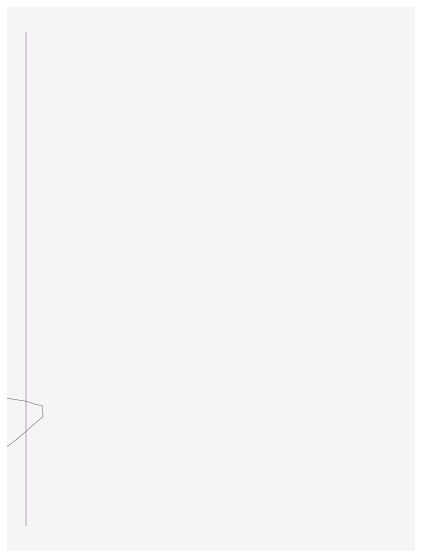

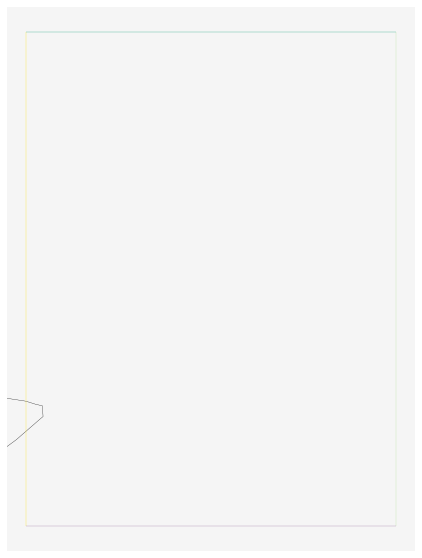

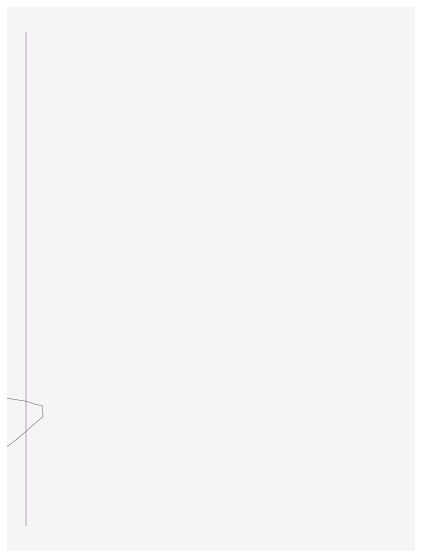

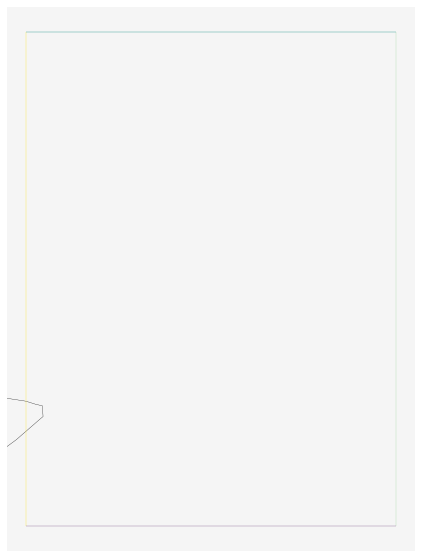

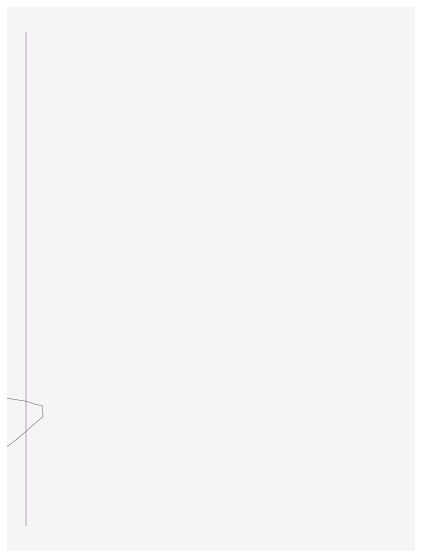

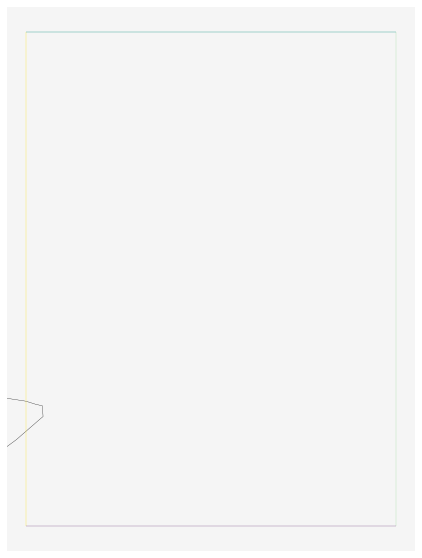

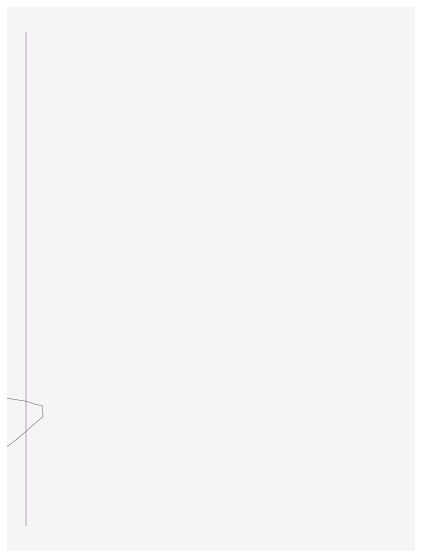

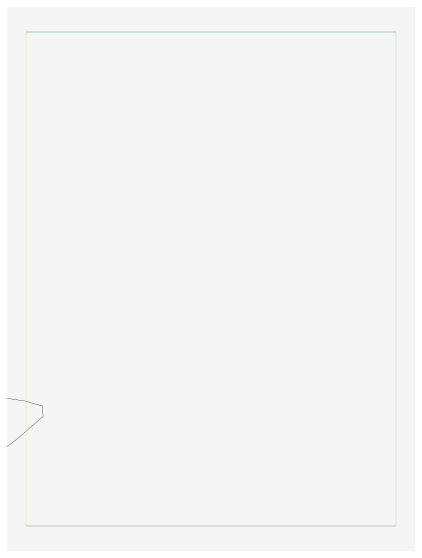

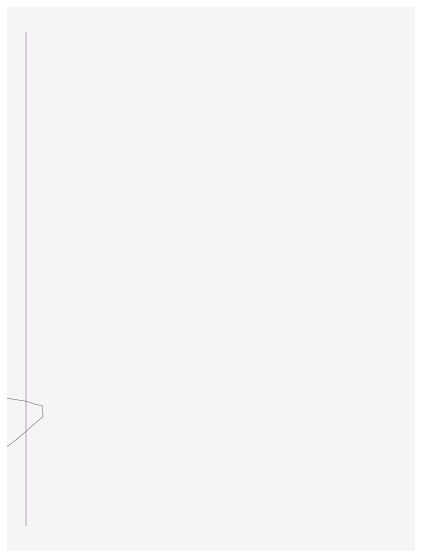

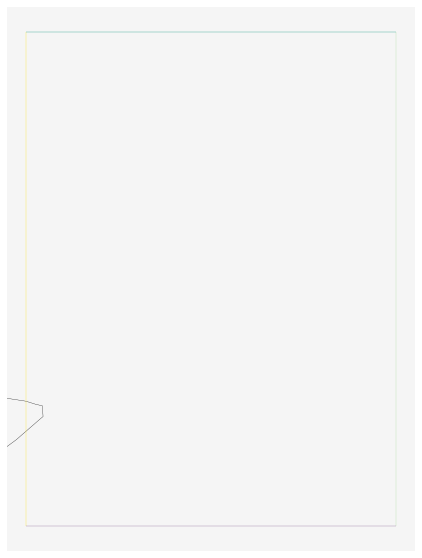

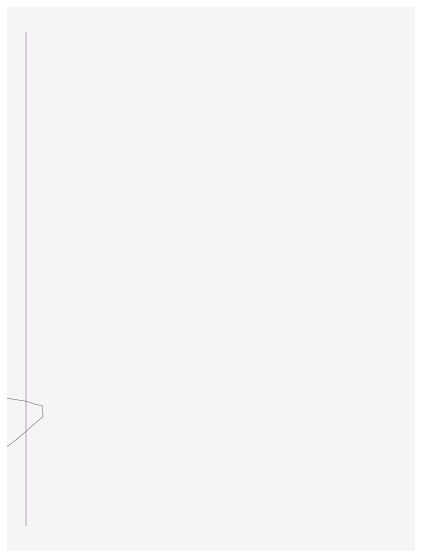

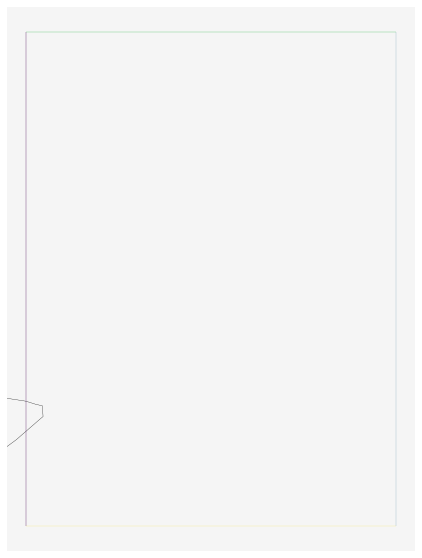

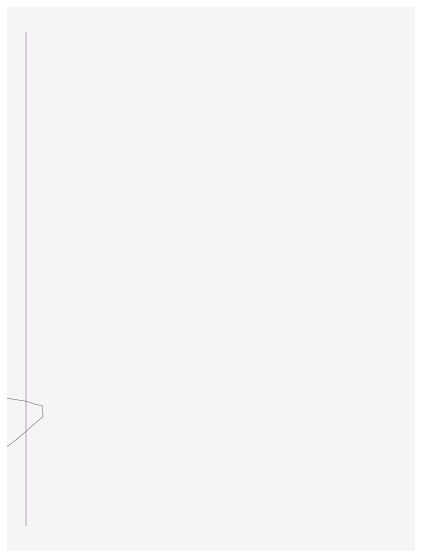

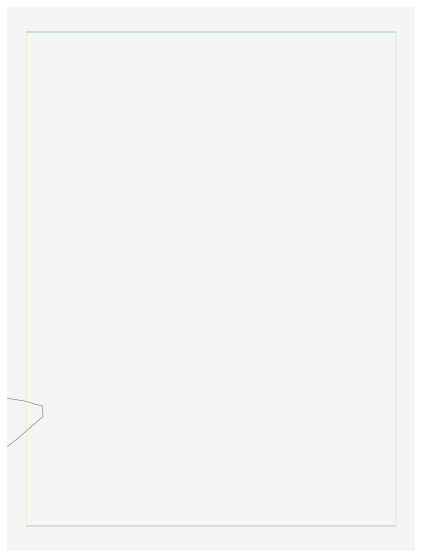

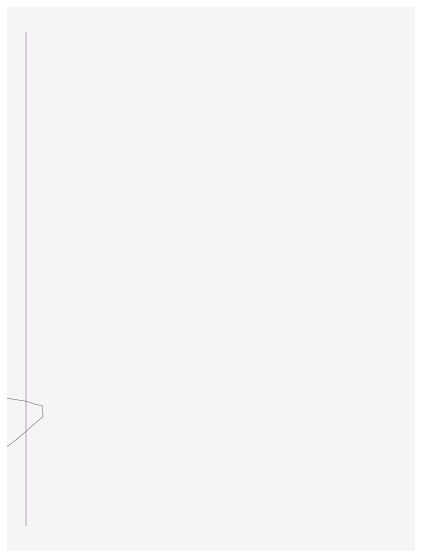

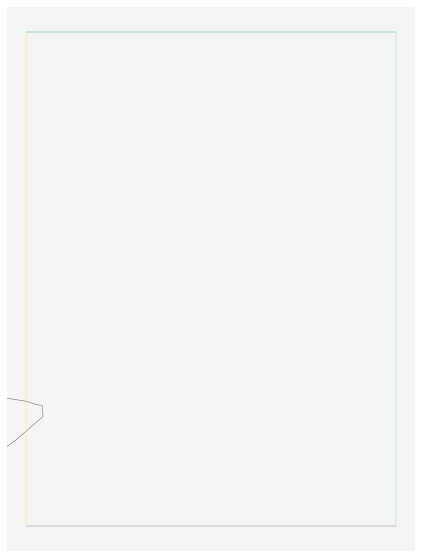

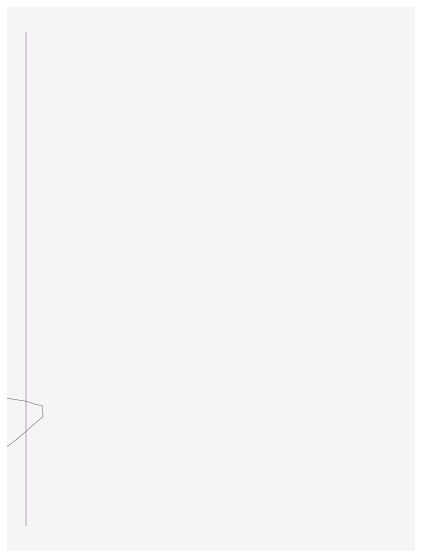

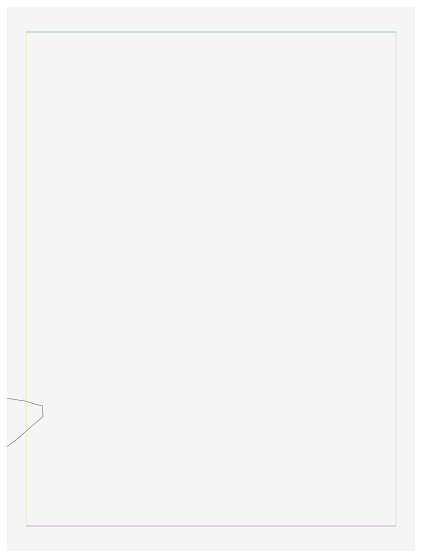

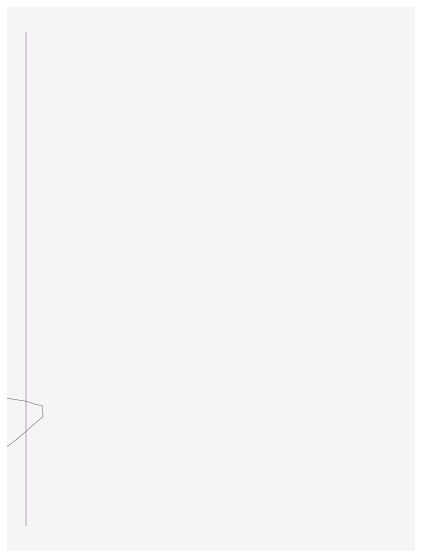

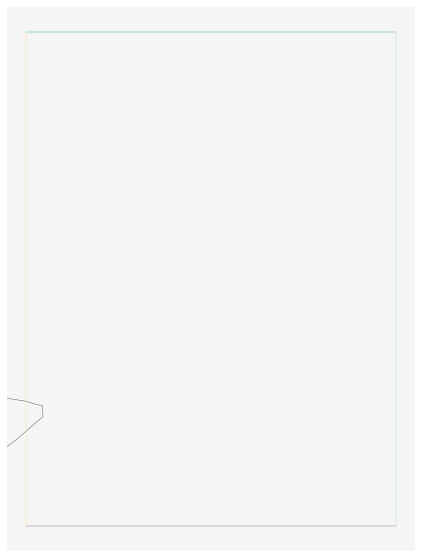

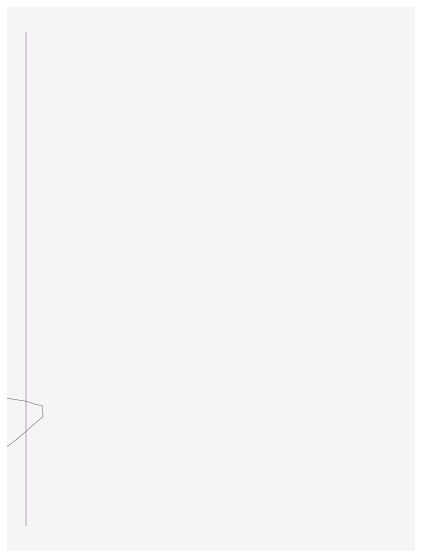

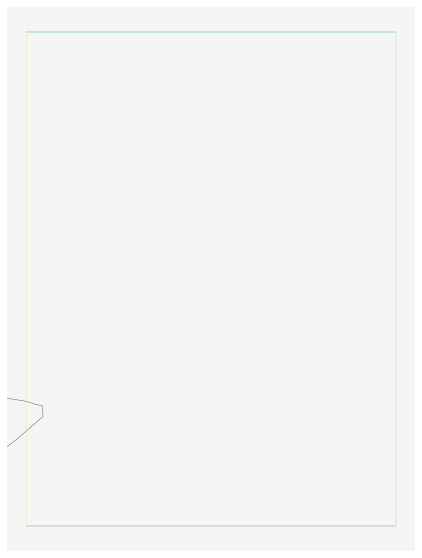

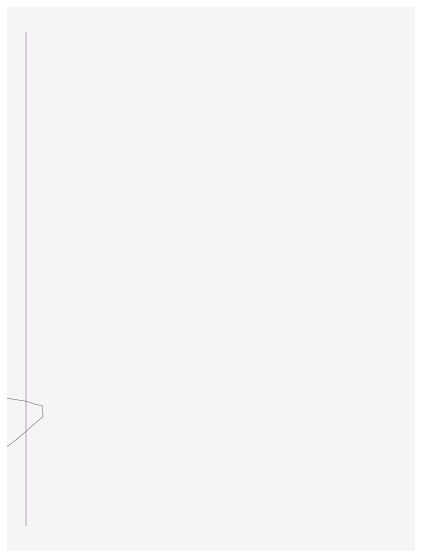

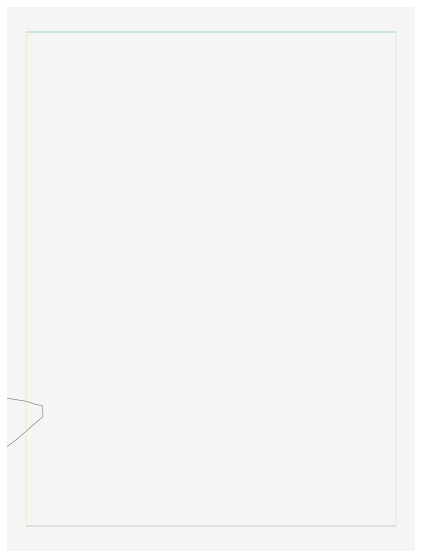

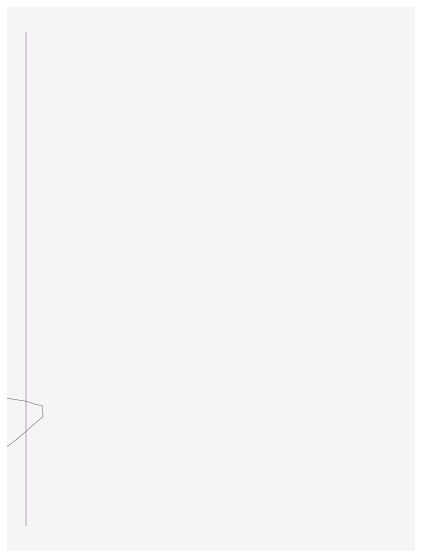

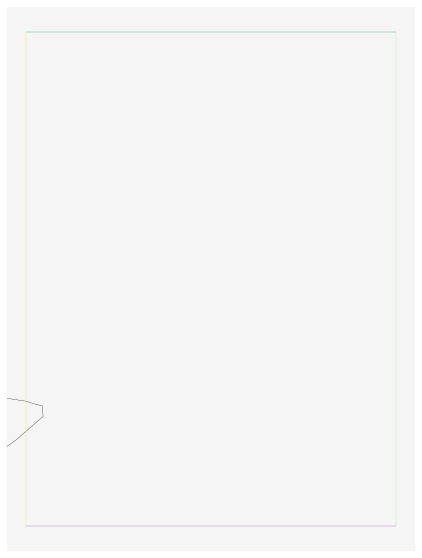

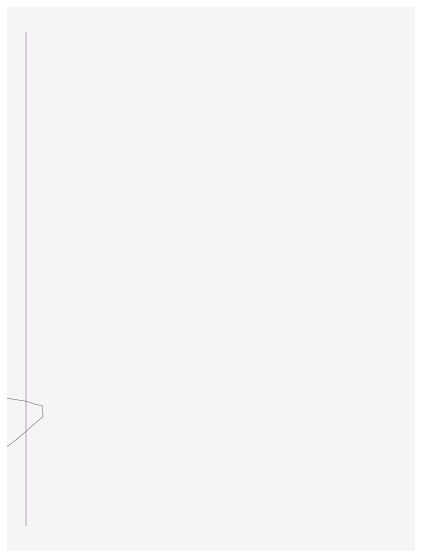

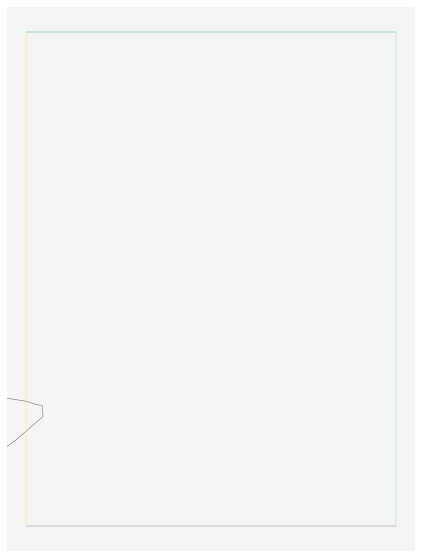

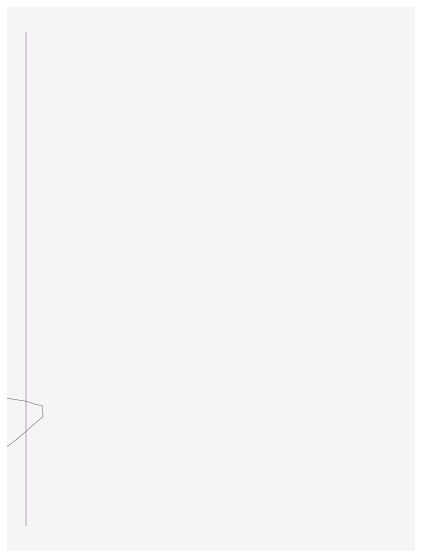

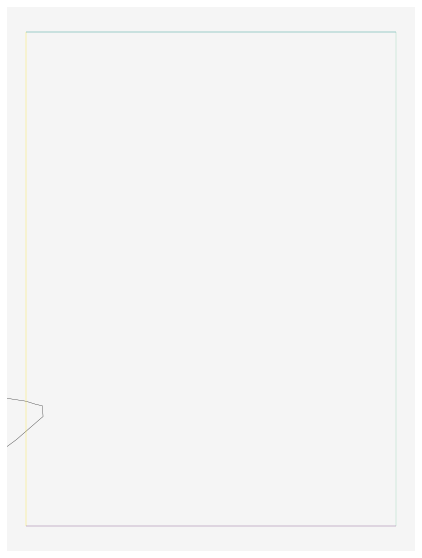

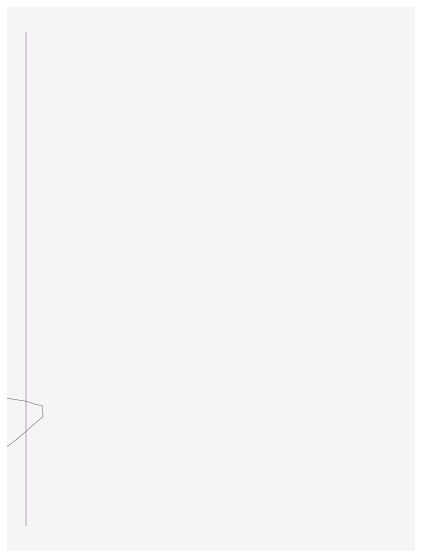

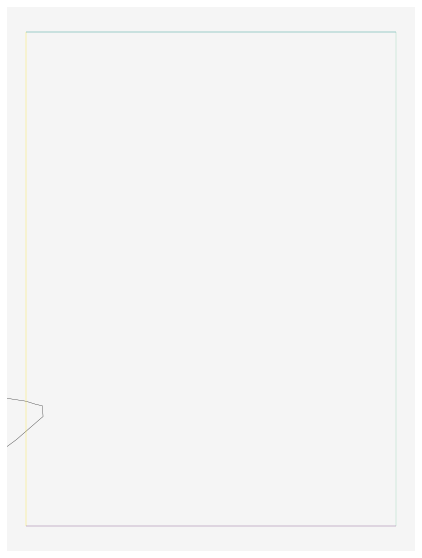

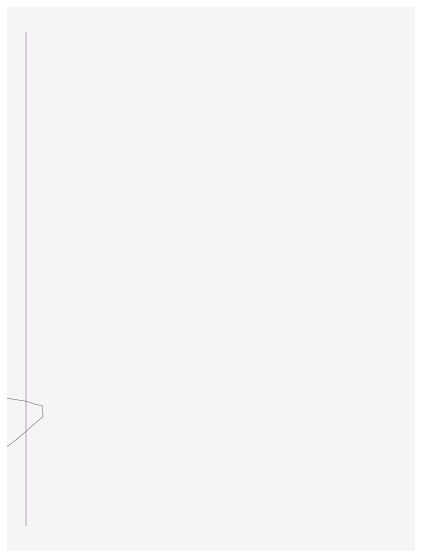

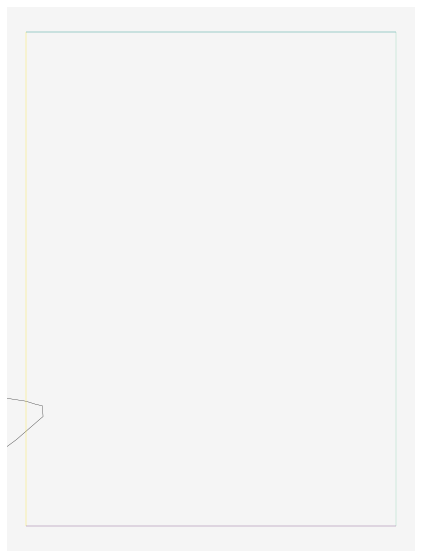

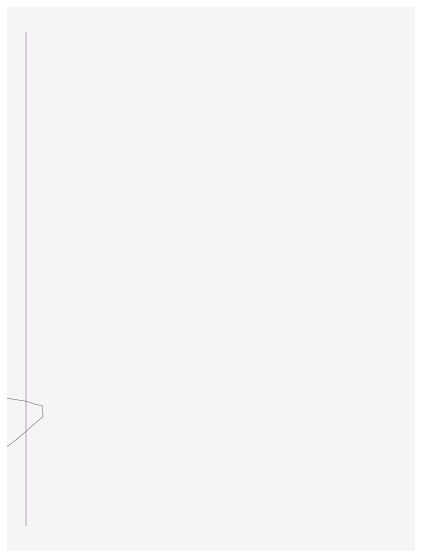

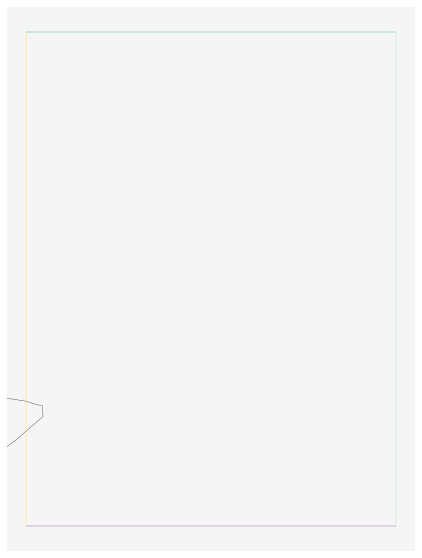

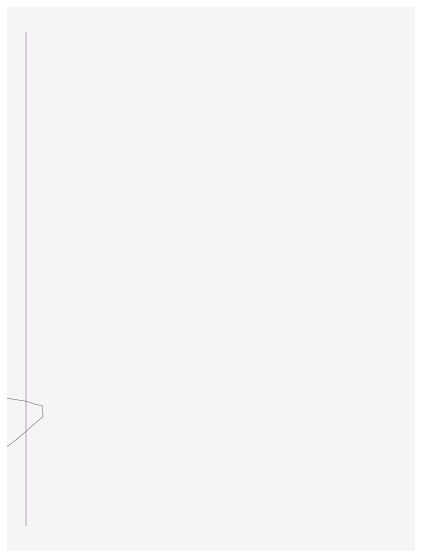

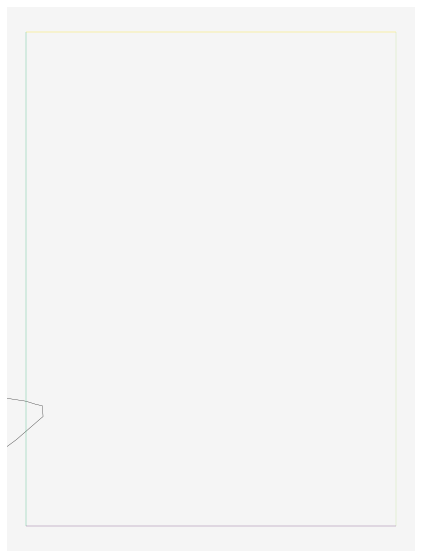

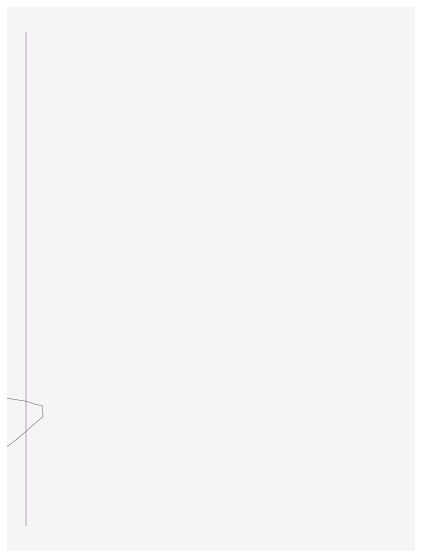

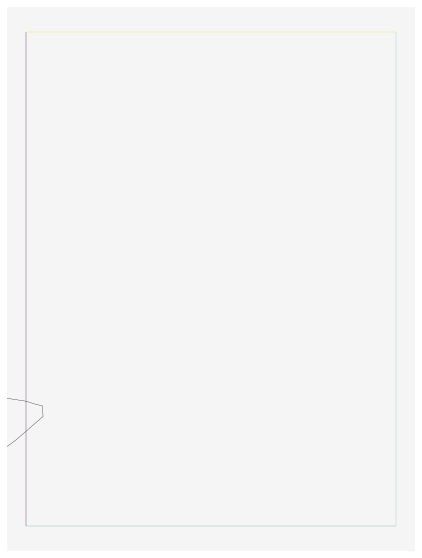

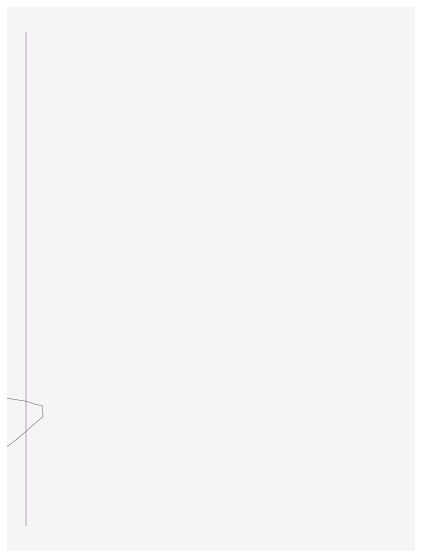

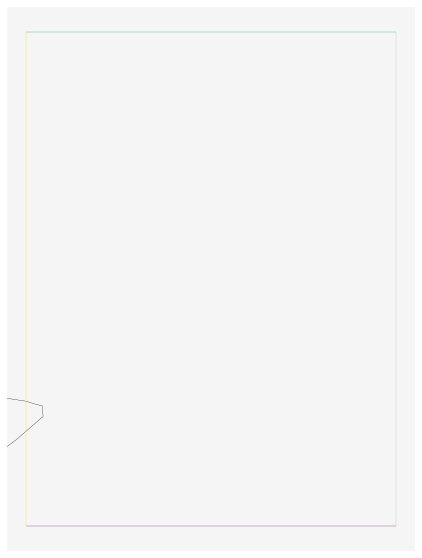

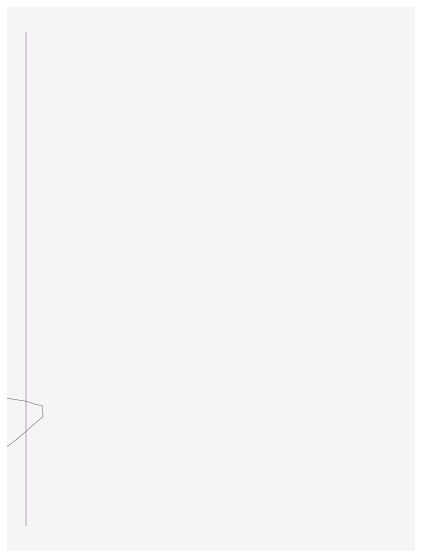

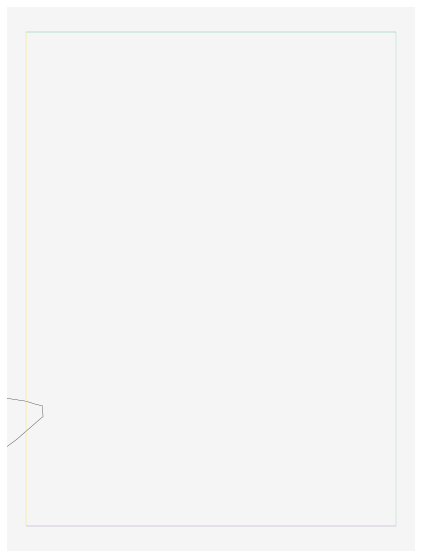

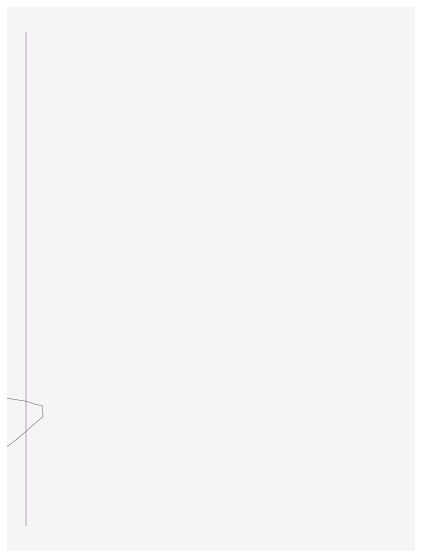

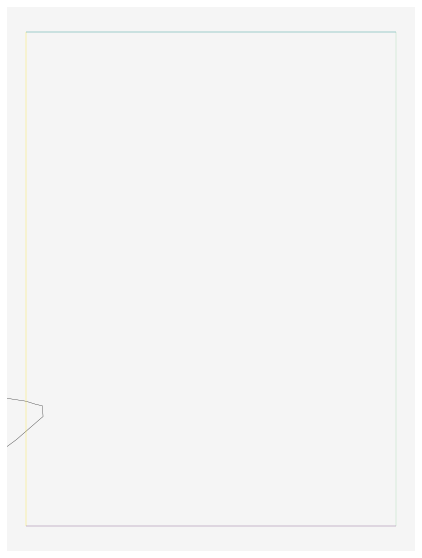

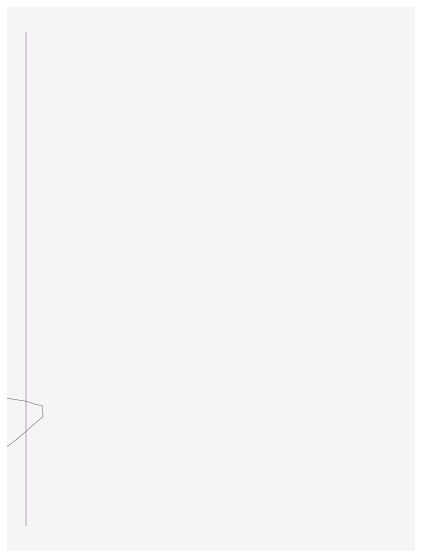

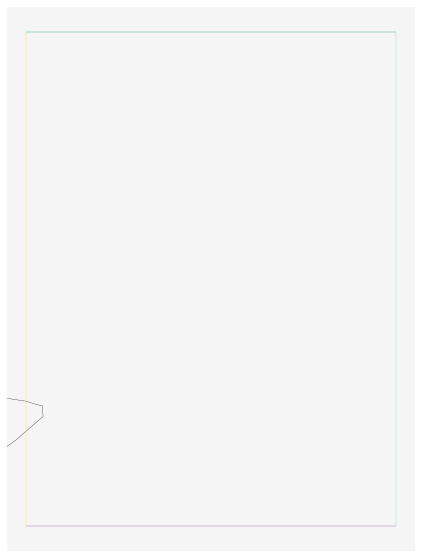

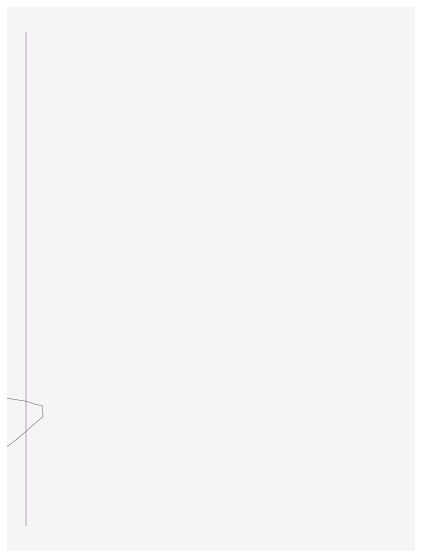

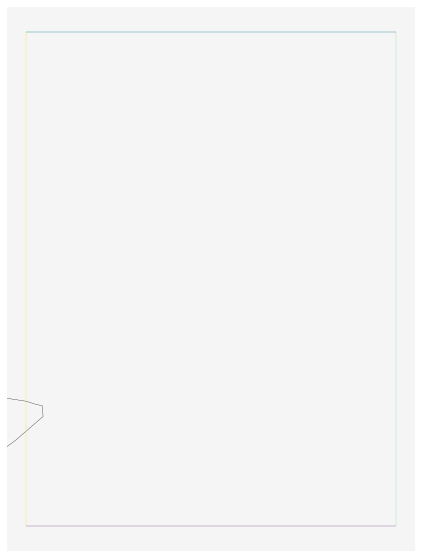

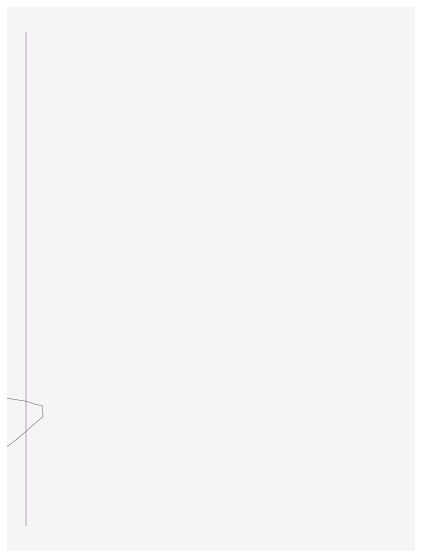

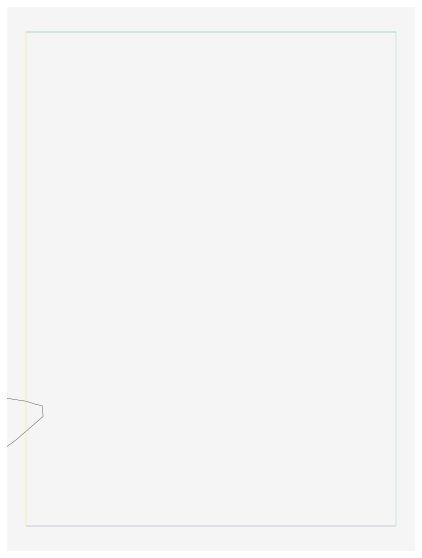

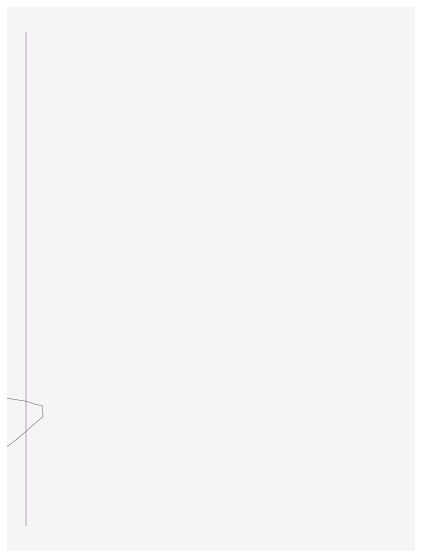

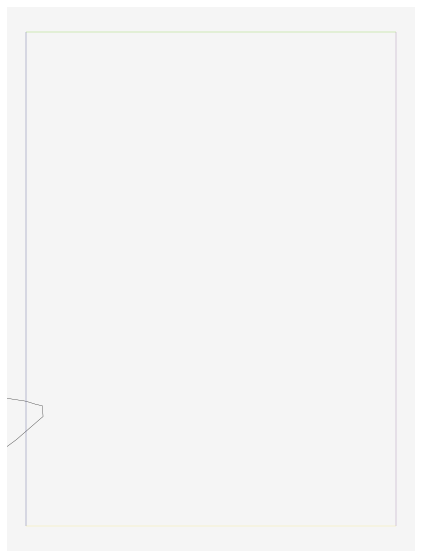

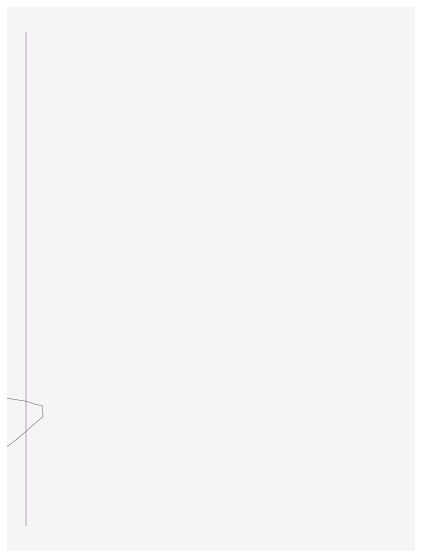

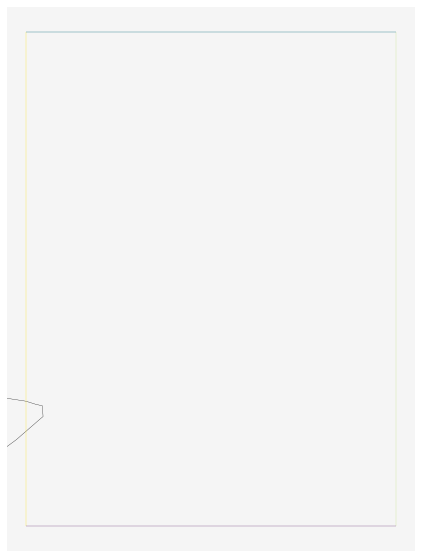

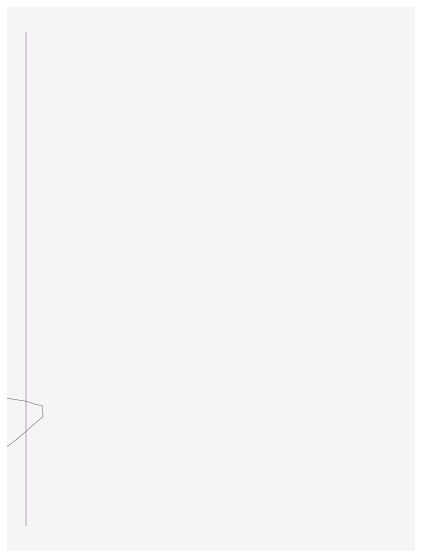

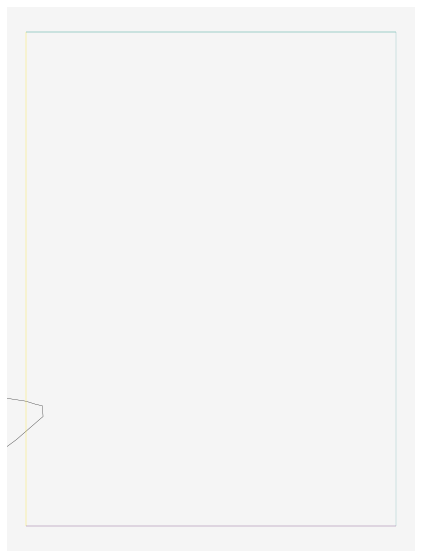

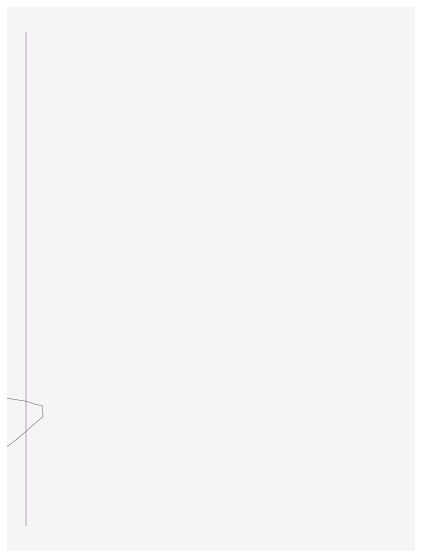

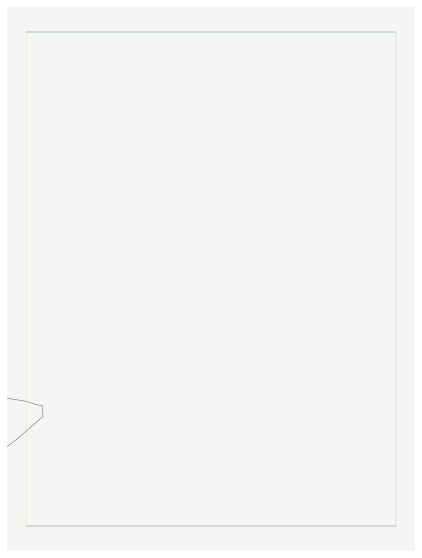

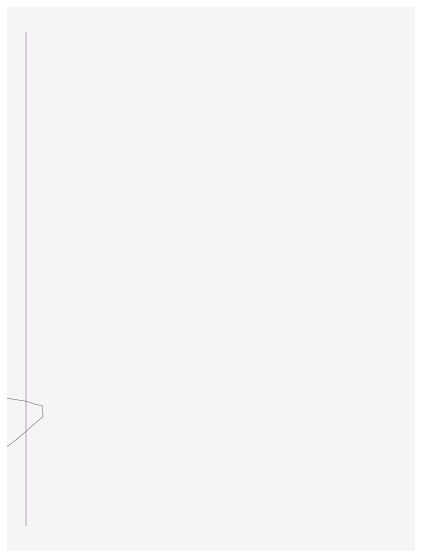

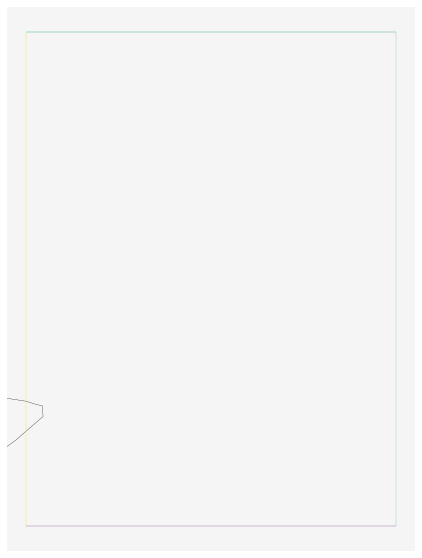

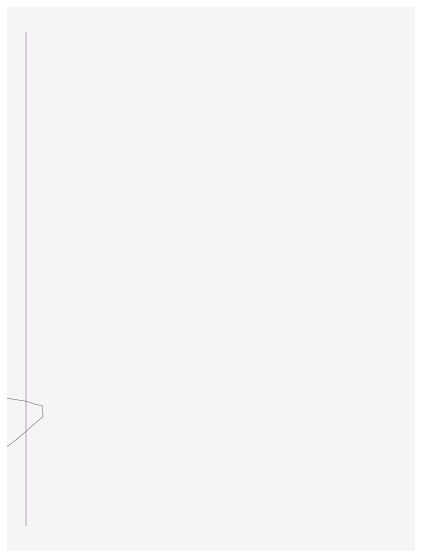

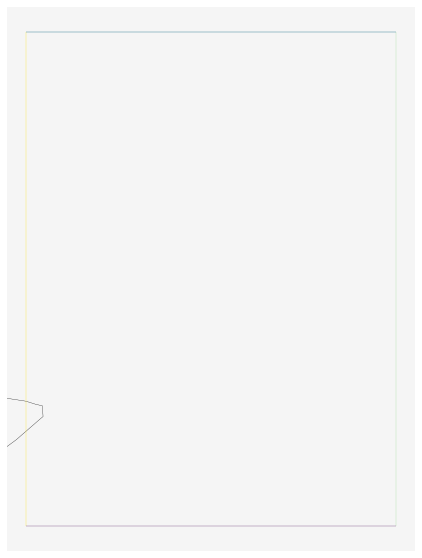

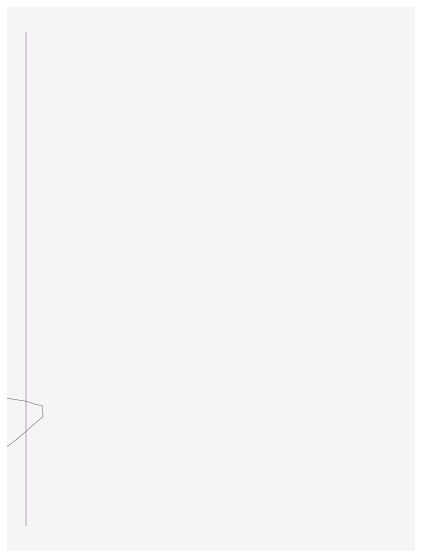

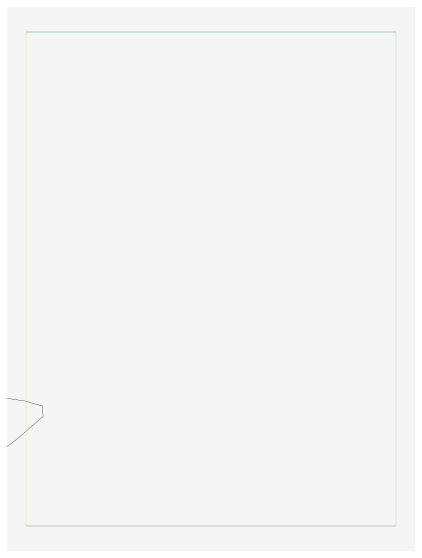

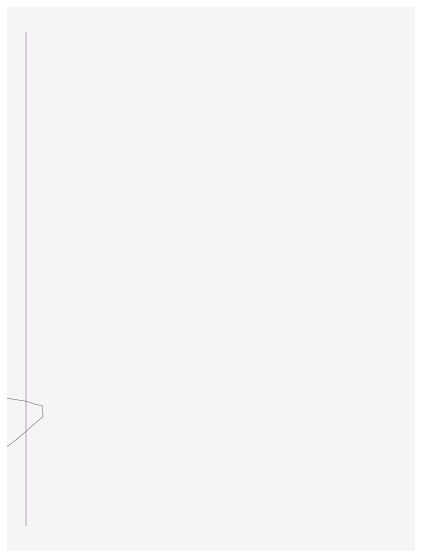

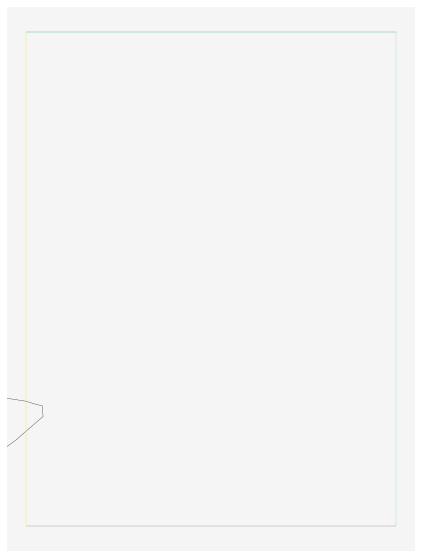

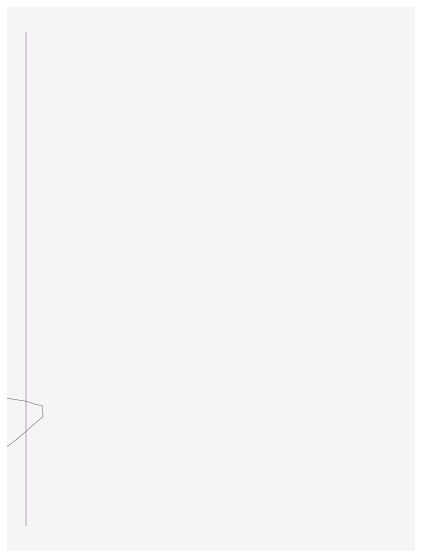

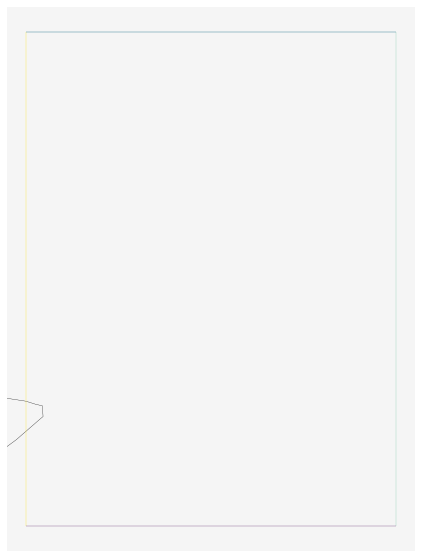

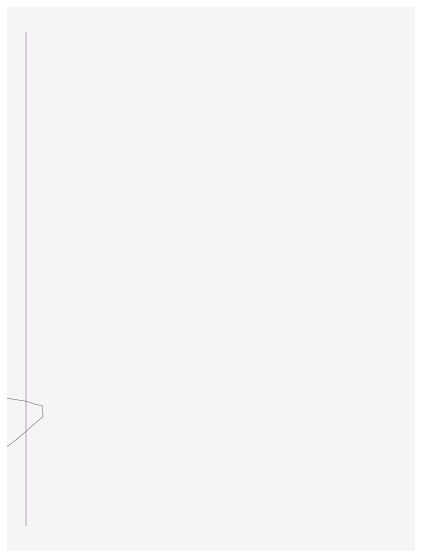

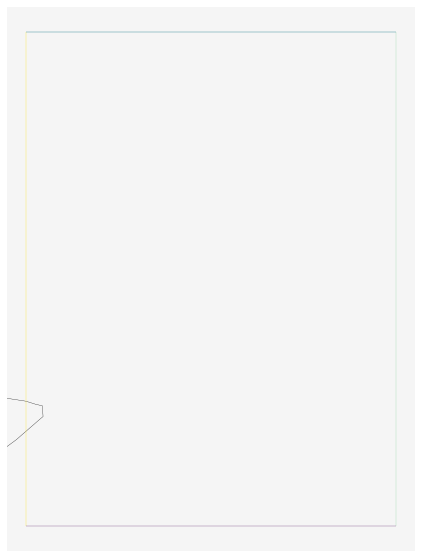

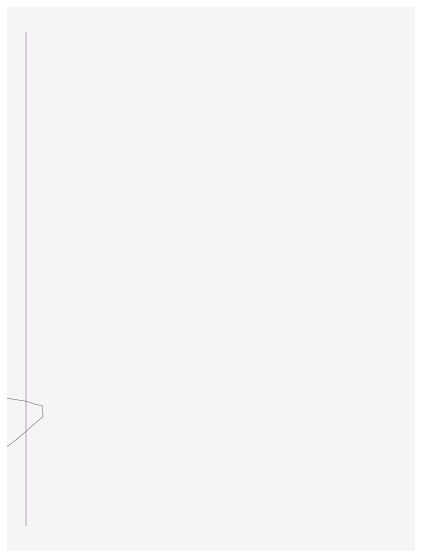

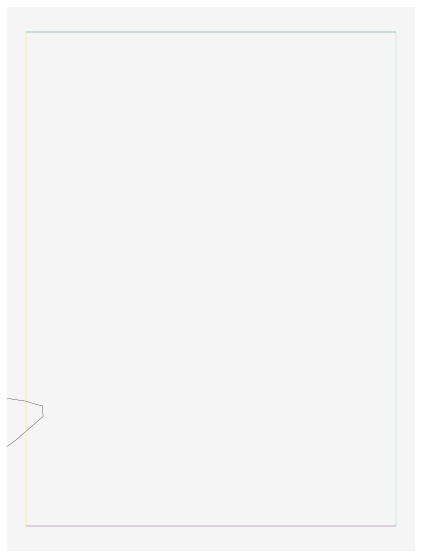

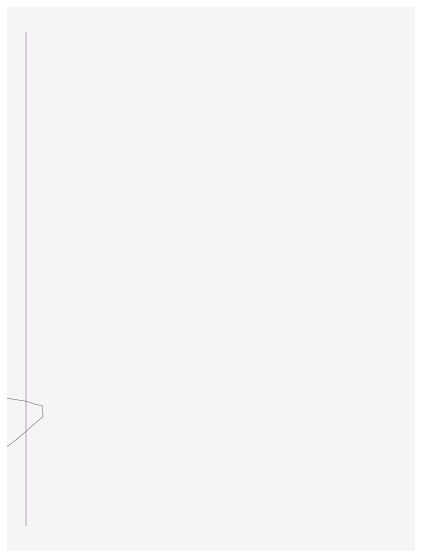

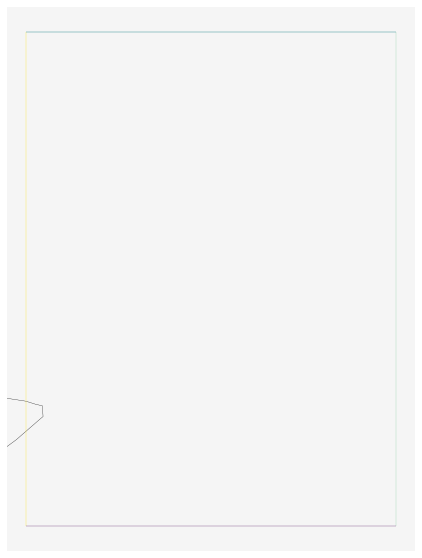

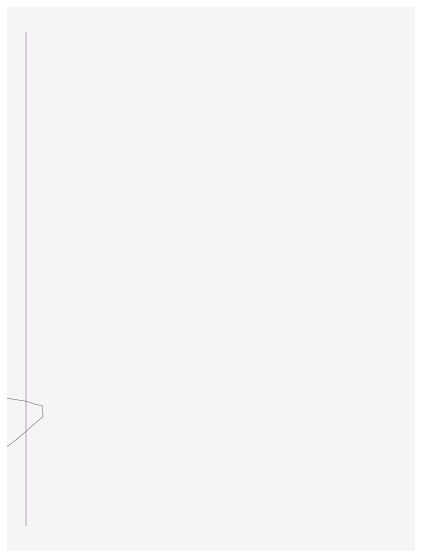

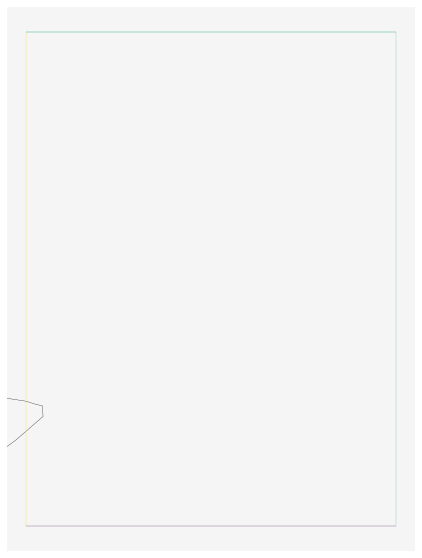

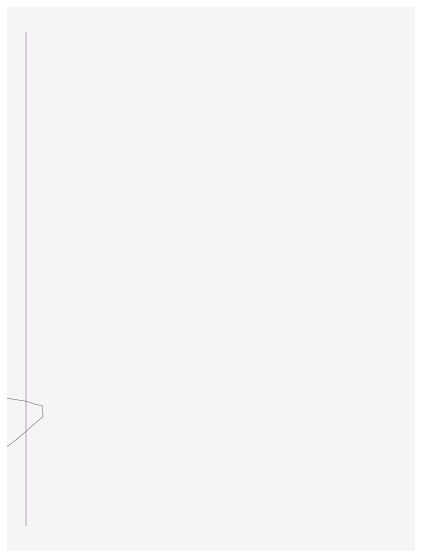

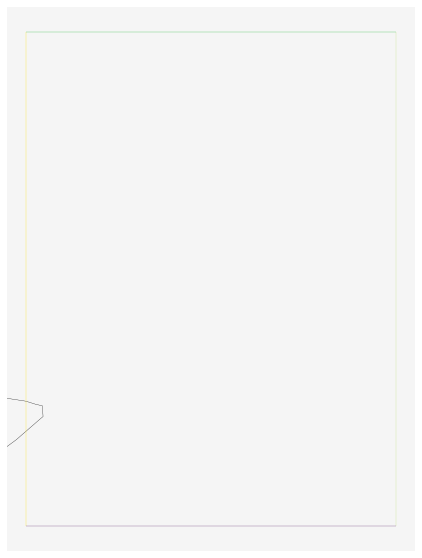

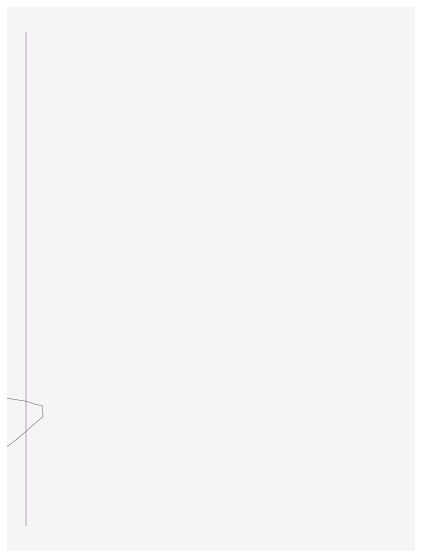

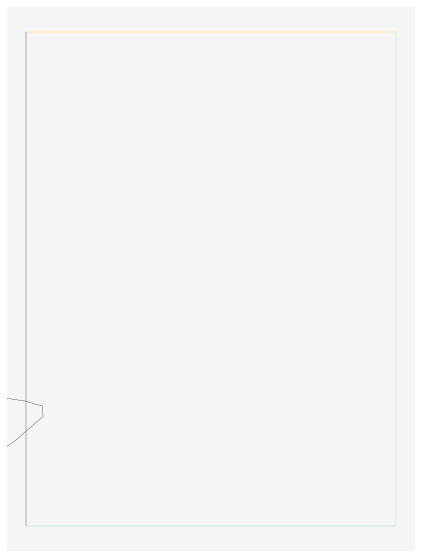

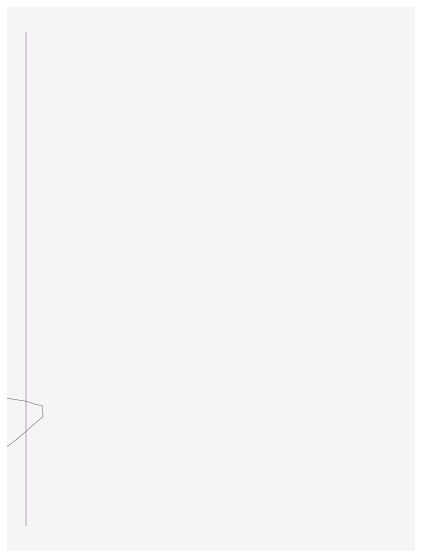

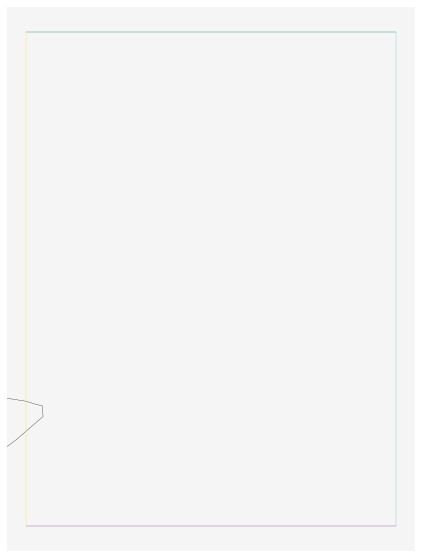

In [6]:
net_work = pypsa.Network()

csv_folder = r"C:\Users\Willem\pypsa-eur\data\minimal_example\input"
csv_folder_lopf = r"C:\Users\Willem\pypsa-eur\data\minimal_example\input_lopf"

# add network components
build_base_network(24*21,1,0,net_work,csv_folder,csv_folder_lopf)

# Run the redispatch workflow with batteries
l_networks = redispatch_workflow(net_work, scenario = "no bat")
l_networks_bat = redispatch_workflow(net_work, scenario = "bat")


In [7]:
# Define all analysis functions for the network

def analyze_objective(l_networks, l_networks_bat):
    '''
    Function for all analysis regarding the objective value (dispatch cost and redispatch cost reduction). 
    '''
    # Daily objective analysis
    # ---------------
    l_networks_d = l_networks[1]
    l_networks_d_bat = l_networks_bat[1]
    l_networks_rd = l_networks[2]
    l_networks_rd_bat = l_networks_bat[2]
    
    # Create dicts with objective value for every day w/o bat and w/ bat
    l_lists = [l_networks_d, l_networks_d_bat, l_networks_rd, l_networks_rd_bat]
    l_dicts = []
    for list_networks in l_lists:
        d_obj = {}
        for network in list_networks:
            d_obj[network.snapshots[0].day] = network.objective
        l_dicts.append(d_obj)
    
    # Create dataframes from dict 
    df_obj_day = pd.DataFrame.from_dict(l_dicts[0], orient = "index").rename(columns={0: "dispatch_cost"})
    df_obj_day.index.rename("day", inplace = True)
    df_obj_day["dispatch_cost_bat"] = pd.DataFrame.from_dict(l_dicts[1], orient = "index")
    df_obj_day["redispatch_cost"] = pd.DataFrame.from_dict(l_dicts[2], orient = "index")
    df_obj_day["redispatch_cost_bat"] = pd.DataFrame.from_dict(l_dicts[3], orient = "index")
    # add additional insights
    df_obj_day["delta_rd"] =  df_obj_day["redispatch_cost_bat"] -  df_obj_day["redispatch_cost"]
    df_obj_day["delta_rd_rel"] = round(df_obj_day["delta_rd"] / df_obj_day["redispatch_cost"], 4)
    df_obj_day["share_rd_d"] = round(df_obj_day["redispatch_cost"] / df_obj_day["dispatch_cost"], 4)
    df_obj_day["share_rd_d_bat"] = round(df_obj_day["redispatch_cost_bat"] / df_obj_day["dispatch_cost_bat"], 4)
    
    # Weekly objective analysis
    # ---------------
    df_obj_week = df_obj_day.iloc[:,2:-3].groupby(df_obj_day.index // 7).sum()
    for col in list(df_obj_week)[:-1]:
        df_obj_week["{}_avg".format(col)] = df_obj_week[col].div(7)
    df_obj_week["delta_rd_avg"] = df_obj_week["redispatch_cost_bat_avg"]-df_obj_week["redispatch_cost_avg"]
    df_obj_week["delta_rd_rel"] = round(df_obj_week["delta_rd"] / df_obj_week["redispatch_cost"], 4) 
      
    # Yearly objective analysis
    # ---------------
    network_rd = concat_network(l_networks_rd)
    network_rd_bat = concat_network(l_networks_rd_bat)
    delta_obj = network_rd.objective - network_rd_bat.objective
    delta_obj_rel = round(delta_obj / network_rd.objective, 4)
        
    return df_obj_day, df_obj_week, delta_obj, delta_obj_rel


# Call objective insights
df_obj_day, df_obj_week, delta_obj, delta_obj_rel = analyze_objective(l_networks, l_networks_bat)
display(df_obj_day)
display(df_obj_week)



,dispatch_cost,dispatch_cost_bat,redispatch_cost,redispatch_cost_bat,delta_rd,delta_rd_rel,share_rd_d,share_rd_d_bat
day,,,,,,,,
1,2.505293e+05,2.505293e+05,2.221227e+05,2.039465e+05,-18176.233954,-0.0818,0.8866,0.8141
2,7.037763e+05,7.037763e+05,5.142803e+05,4.290340e+05,-85246.288944,-0.1658,0.7307,0.6096
3,1.599243e+06,1.599243e+06,2.840413e+05,2.211736e+05,-62867.693326,-0.2213,0.1776,0.1383
4,1.013820e+06,1.013820e+06,6.993105e+05,6.186864e+05,-80624.136873,-0.1153,0.6898,0.6103
5,7.053173e+05,7.053173e+05,2.255116e+05,1.698156e+05,-55696.004022,-0.2470,0.3197,0.2408
...,...,...,...,...,...,...,...,...
17,8.809287e+05,8.809287e+05,1.196659e+06,1.108947e+06,-87712.076719,-0.0733,1.3584,1.2588
18,1.932041e+06,1.932041e+06,2.702860e+05,2.083387e+05,-61947.239702,-0.2292,0.1399,0.1078
19,1.537187e+06,1.537187e+06,2.690857e+04,1.525671e+04,-11651.862042,-0.4330,0.0175,0.0099


,redispatch_cost,redispatch_cost_bat,delta_rd,redispatch_cost_avg,redispatch_cost_bat_avg,delta_rd_avg,delta_rd_rel
day,,,,,,,
0,1.973882e+06,1.655976e+06,-317906.001272,281983.172734,236568.029695,-45415.143039,-0.1611
1,5.197312e+06,4.647255e+06,-550057.447101,742473.152619,663893.517319,-78579.635300,-0.1058
2,4.735927e+06,4.307439e+06,-428487.944388,676560.986286,615348.422802,-61212.563484,-0.0905
3,1.259402e+05,6.361193e+04,-62328.242200,17991.453320,9087.418720,-8904.034600,-0.4949


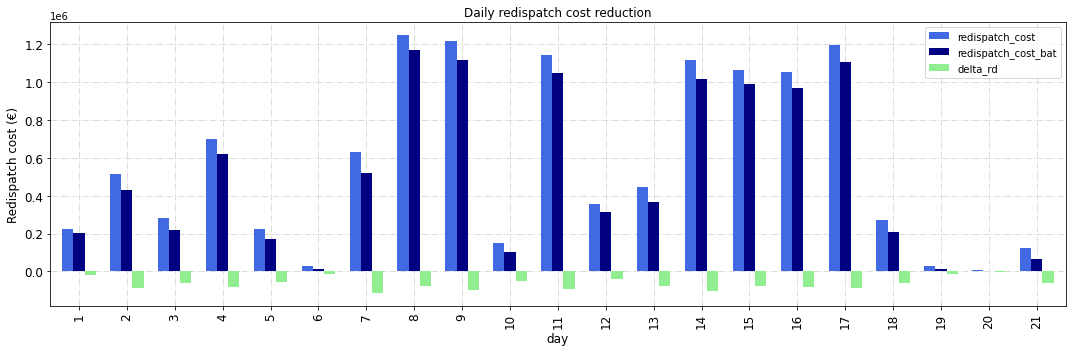

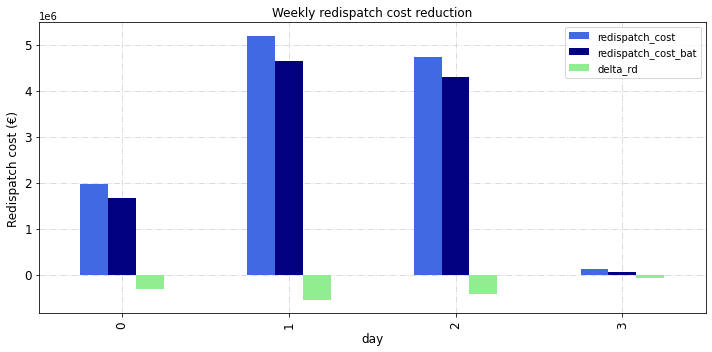

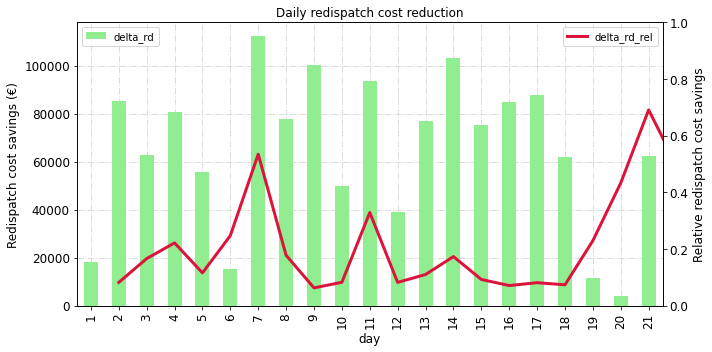

In [8]:
# Plot objective insights
# --------------
colors = ["royalblue","navy","lightgreen"]

# Redispatch cost difference per day
cols = ["redispatch_cost","redispatch_cost_bat","delta_rd"]
fig, ax  = plt.subplots(figsize = (15, 5))
ax.set_ylabel('Redispatch cost (€)',  fontsize = 12)
ax.set_xlabel("Time horizon (day)", fontsize = 12)
df_obj_day[cols].plot.bar(stacked = False, ax = ax, title = "Daily redispatch cost reduction", 
                                   color = colors, legend = True, width = 0.7, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '-.', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Redispatch cost difference per week
cols = ["redispatch_cost","redispatch_cost_bat","delta_rd"]
fig, ax  = plt.subplots(figsize = (10, 5))
ax.set_ylabel('Redispatch cost (€)',  fontsize = 12)
ax.set_xlabel("Time horizon (week)", fontsize = 12)
df_obj_week[cols].plot.bar(stacked = False, ax = ax, title = "Weekly redispatch cost reduction", 
                                   color = colors, legend = True, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '-.', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Relative redispatch cost savings vs absolute savings
fig, ax2  = plt.subplots(figsize = (10, 5))
ax2.set_ylabel('Redispatch cost savings (€)',  fontsize = 12)
ax2.set_xlabel("Time horizon (day)", fontsize = 12)
ax2 = df_obj_day["delta_rd"].abs().plot.bar(stacked = False, ax = ax2, title = "Daily redispatch cost reduction", 
                                   color = ["lightgreen"], legend = True, fontsize = 12)
ax2.set_facecolor('white')
ax2.legend(loc = "upper left")
ax2.grid(color = 'gainsboro', linestyle = '-.', linewidth = 1.0)
ax2.set_axisbelow(True)

# TODO: REMOVE GRAPH OFFSET

ax2_ = ax2.twinx()
df_obj_day["delta_rd_rel"].abs().plot.line(ax = ax2_, linewidth = 3, color = "crimson", legend = True, fontsize = 12)
ax2_.set_ylabel('Relative redispatch cost savings',  fontsize = 12)
ax2_.set_ylim(0,1.0)
fig.tight_layout()
plt.show()


In [9]:
# ---------------
# Extract results from dispatch & redispatch optimization
#
# Analysis:

# - reduction of line overloading (time with line cap. at 100%)
# - change in merit order dispatch -> redispatch: merit order plotten dispatch vs. redispatch mit und ohne batterien (an beispielhaften
#   tagen mit besonders hoher, mittlerer, und geringer last)
#
# Retionalization of analysis
# - reduction of ramp up/down at specific locations (locations = groups of buses (by their name/number) especially in the north as well as the south)
# - most overloaded lines (lines at 100% capacity), buses with most redispatch energy

# prepare redispatch workflow output for analysis
l_network = prepare_for_analysis(l_networks)
l_network_bat = prepare_for_analysis(l_networks_bat)

network = l_networks_bat[1]
network_rd = l_network[2]
network_rd_bat = l_network_bat[2]


# Reduction of redispatch energy (positive and negative)
# -----------------------

# Redispatch power dataframe
cols_rd = [column for column in list(network_rd.generators_t.p) if "pos" in column or "neg" in column]         
df_rd_p = network_rd.generators_t.p[cols_rd]
df_rd_p_bat = network_rd_bat.generators_t.p[cols_rd]
# sum of positive redispatch
cols_pos = [column for column in list(df_rd_p) if "pos" in column]
df_rd_p["Positive redispatch"] = df_rd_p.loc[:,cols_pos].sum(axis = 1)
df_rd_p_bat["Positive redispatch"] = df_rd_p_bat.loc[:,cols_pos].sum(axis = 1)
# sum of negative redispatch
cols_neg = [column for column in list(df_rd_p) if "neg" in column]
df_rd_p["Negative redispatch"] = df_rd_p.loc[:,cols_neg].sum(axis = 1)
df_rd_p_bat["Negative redispatch"] = df_rd_p_bat.loc[:,cols_neg].sum(axis = 1)


# Difference of redispatch (pos/neg) and total redispatch datarame
df_bat_nobat = pd.concat([df_rd_p[["Negative redispatch", "Positive redispatch"]], 
                             df_rd_p_bat[["Negative redispatch", "Positive redispatch"]]], 
                            axis = 1)
df_bat_nobat.columns = ["Negative redispatch", "Positive redispatch",
                       "Negative redispatch bat", "Positive redispatch bat"]
# differences in redispatch bat vs no bat
df_bat_nobat["Difference in curtailment"] = df_bat_nobat.iloc[:,2] - df_bat_nobat.iloc[:,0]
df_bat_nobat["Difference in ramp-up"] = df_bat_nobat.iloc[:,3] - df_bat_nobat.iloc[:,1]
df_bat_nobat["Total redispatch"] = abs(df_bat_nobat.loc[:,["Negative redispatch", 
                                                           "Positive redispatch"]]).sum(axis = 1).round(1)
df_bat_nobat["Total redispatch bat"] = abs(df_bat_nobat.loc[:,["Negative redispatch bat", 
                                                "Positive redispatch bat"]]).sum(axis = 1).round(1)
df_bat_nobat["Total redispatch difference"] = df_bat_nobat["Total redispatch bat"] - df_bat_nobat["Total redispatch"]
display(df_bat_nobat)



        

# # Dispatch time series
# df_dispatch_t = network.generators_t.p.copy()
# df_dispatch_t["Sum"] = df_dispatch_t.sum(axis = 1)





,Negative redispatch,Positive redispatch,Negative redispatch bat,Positive redispatch bat,Difference in curtailment,Difference in ramp-up,Total redispatch,Total redispatch bat,Total redispatch difference
2019-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2019-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2019-01-01 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2019-01-01 03:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2019-01-01 04:00:00,-19.316377,19.316377,-17.879597,0.000000,1.436780,-19.316377,38.6,17.9,-20.7
...,...,...,...,...,...,...,...,...,...
2019-01-21 19:00:00,-59.419967,59.419967,0.000000,0.000000,59.419967,-59.419967,118.8,0.0,-118.8
2019-01-21 20:00:00,-142.185434,142.185434,-82.890358,0.000000,59.295076,-142.185434,284.4,82.9,-201.5
2019-01-21 21:00:00,-105.921746,105.921746,-140.404468,0.000000,-34.482722,-105.921746,211.8,140.4,-71.4
2019-01-21 22:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


NameError: name 'df_bess_t_p' is not defined

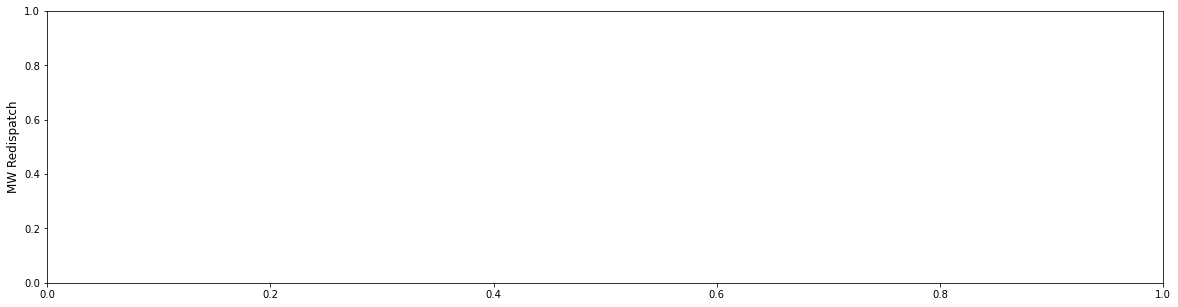

In [10]:
# # Redispatch w/o batteries
# # ------------------------

# # Redispatch df
# df_redispatch_t = network_rd.generators_t.p.copy()
# cols_rd = [column for column in list(df_redispatch_t) if "pos" in column or "neg" in column]         
# df_redispatch_t = df_redispatch_t.copy()[cols_rd]

# # Resulting dispatch after redispatch
# #display(df_redispatch_t)

# # Absolute redispatch df
# df_redispatch_abs = df_redispatch_t.abs()
# df_redispatch_abs["Sum"] = df_redispatch_abs.sum(axis = 1)

# # df for positive rd
# cols_rd_pos = [column for column in list(df_redispatch_t) if "pos" in column]         
# df_redispatch_t_pos = df_redispatch_t.copy()[cols_rd_pos]
# df_redispatch_t_pos["Sum pos"] = df_redispatch_t_pos.sum(axis = 1)

# # df for negative rd
# cols_rd_neg = [column for column in list(df_redispatch_t) if "neg" in column]         
# df_redispatch_t_neg = df_redispatch_t.copy()[cols_rd_neg]
# df_redispatch_t_neg["Sum neg"] = df_redispatch_t_neg.sum(axis = 1)

# # Add sums to redispatch df
# df_redispatch_t["Sum pos"] = df_redispatch_t_pos["Sum pos"]
# df_redispatch_t["Sum neg"] = df_redispatch_t_neg["Sum neg"]


# # Redispatch w/ batteries
# # ------------------------

# # Redispatch time series with batteries
# df_redispatch_t_bat = network_rd_bat.generators_t.p.copy()
# cols_rd = [column for column in list(df_redispatch_t_bat) if "pos" in column or "neg" in column]         
# df_redispatch_t_bat = df_redispatch_t_bat[cols_rd].copy()

# # Absolute redispatch df
# df_redispatch_abs = df_redispatch_t_bat.abs()
# df_redispatch_abs["Sum"] = df_redispatch_abs.sum(axis = 1)

# # df for positive rd
# cols_rd_pos = [column for column in list(df_redispatch_t_bat) if "pos" in column]         
# df_redispatch_t_bat_pos = df_redispatch_t_bat.copy()[cols_rd_pos]
# df_redispatch_t_bat_pos["Sum pos"] = df_redispatch_t_bat_pos.sum(axis = 1)

# # df for negative rd
# cols_rd_neg = [column for column in list(df_redispatch_t_bat) if "neg" in column]         
# df_redispatch_t_bat_neg = df_redispatch_t_bat.copy()[cols_rd_neg]
# df_redispatch_t_bat_neg["Sum neg"] = df_redispatch_t_bat_neg.sum(axis = 1)

# # Add sums to redispatch df
# df_redispatch_t_bat["Sum pos"] = df_redispatch_t_bat_pos["Sum pos"]
# df_redispatch_t_bat["Sum neg"] = df_redispatch_t_bat_neg["Sum neg"]


# # battery charging operations (of all batteries)
# df_bess = network_rd_bat.stores
# df_bess_t_p = network_rd_bat.stores_t.p
# df_bess_SOC = (network_rd_bat.stores_t.e / network_rd_bat.stores.e_nom.T).dropna(axis = 1)
# display(df_bess_SOC)


# ------------------------
# Plots w/o bat
# ------------------------

# # Dispatch time series
# cols = list(df_dispatch_t)[:-1]
# fig, ax  = plt.subplots(figsize = (10, 5))
# ax.set_ylabel('MW Redispatch',  fontsize = 12)
# ax = df_dispatch_t.loc[:, cols].plot.bar(stacked = True, ax = ax, title = "Dispatch after market clearing", legend = True, fontsize = 12)
# ax.set_facecolor('white')
# ax.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# # Redispatch time series (pos vs. neg aggregate) 
# cols_0 = list(df_redispatch_t)[-2:]
# fig, ax_0  = plt.subplots(figsize = (10, 5))
# ax_0.set_ylabel('MW Redispatch',  fontsize = 12)
# ax_0 = df_redispatch_t.loc[:, cols_0].plot.bar(stacked = True, ax = ax_0, title = "Amount of redispatch", legend = True, fontsize = 12)
# ax_0.set_facecolor('white')
# ax_0.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# # Redispatch time series (aggregate) 
# cols_1 = list(df_redispatch_abs)[:-1]
# fig, ax_1  = plt.subplots(figsize = (10, 5))
# ax_1.set_ylabel('MW Redispatch',  fontsize = 12)
# ax_1 = df_redispatch_abs.loc[:, cols_1].plot.bar(stacked = True, ax = ax_1, title = "Aggregated amount of redispatch", legend = True, fontsize = 12)
# ax_1.set_facecolor('white')
# ax_1.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# # Redispatch time series (positive rd) 
# cols_2 = list(df_redispatch_t_pos)[:-1]
# fig, ax_2  = plt.subplots(figsize = (10, 5))
# ax_2.set_ylabel('MW Redispatch',  fontsize = 12)
# ax_2 = df_redispatch_t_pos.loc[:, cols_2].plot.bar(stacked = True, ax = ax_2, title = "Amount of positive redispatch (ramp up)", legend = True, fontsize = 12)
# ax_2.set_facecolor('white')
# ax_2.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# # Redispatch time series (negative rd) 
# cols_3 = list(df_redispatch_t_neg)[:-1]
# fig, ax_3  = plt.subplots(figsize = (10, 5))
# ax_3.set_ylabel('MW Redispatch',  fontsize = 12)
# ax_3 = df_redispatch_t_neg.loc[:, cols_3].plot.bar(stacked = True, ax = ax_3, title = "Amount of negative redispatch (curtailment)", legend = True, fontsize = 12)
# ax_3.set_facecolor('white')
# ax_3.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# # Plots w/ bat
# # ------------------------

# # Redispatch time series (pos vs. neg aggregate) 
# cols_4 = list(df_redispatch_t_bat)[-2:]
# fig, ax_4  = plt.subplots(figsize = (20, 5))
# ax_4.set_ylabel('MW Redispatch',  fontsize = 12)
# ax_4 = df_redispatch_t_bat.loc[:, cols_4].plot.bar(stacked = True, ax = ax_4, title = "Amount of positive and negative redispatch", legend = True, fontsize = 12)
# ax_4.set_facecolor('white')
# ax_4.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# # Difference positive vs negative redispatch 
# cols_5 = list(df_bat_vs_nobat)[-2:]
# fig, ax_5  = plt.subplots(figsize = (20, 5))
# ax_5.set_ylabel('MW Redispatch',  fontsize = 12)
# ax_5 = df_bat_vs_nobat.loc[:, cols_5].plot.bar(stacked = True, ax = ax_5, title = "Difference between redispatch with and without bat", legend = True, fontsize = 12)
# ax_5.set_facecolor('white')
# ax_5.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# Plots battery insights
# ------------------------

# Battery charging operations (battery in the north)
cols_6 = ["BESS_1","BESS_2","BESS_3"]
fig, ax_6  = plt.subplots(figsize = (20, 5))
ax_6.set_ylabel('MW Redispatch',  fontsize = 12)
ax_6 = df_bess_t_p.loc[:, cols_6].plot.bar(stacked = True, ax = ax_6, title = "Battery active power in redispatch", legend = True, fontsize = 12)
ax_6.set_facecolor('white')
ax_6.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# Battery SOC
cols_7 = list(df_bess_SOC)
fig, ax_7  = plt.subplots(figsize = (10, 5))
ax_7.set_ylabel('Battery SOC',  fontsize = 12)
ax_7 = df_bess_SOC.loc[:, cols_7].plot.line(stacked = False, ax = ax_7, title = "Battery SOC during redispatch", legend = True, fontsize = 12)
ax_7.set_facecolor('white')
ax_7.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

In [43]:
#################### 
# CO2 analysis
#
# Analysis outcomes:
# - CO2 savings of generators according to their marginal CO2 emissions
# - Wind curtailment (offshore and onshore)
# - Solar PV curtailment
# 
####################

# function to assign co2 values
def map_values(row, values_dict):
    return values_dict[row]

# dataframes with all dispatch & redispatch info together
display(df_rd_p)
display(df_rd_p_bat)

# FOR PYPSA-EUR: marginal co2 emissions are in the network.carriers variable

# dicts with co2 data
df_co2_data = pd.read_csv(r"C:\Users\Willem\pypsa-eur\data\costs.csv", sep = ",", encoding='latin-1')
df_co2_data = df_co2_data[df_co2_data['parameter'] == "CO2 intensity"][["technology","parameter","value","unit"]]
df_co2_data = df_co2_data.set_index("technology")
dict_co2_data = df_co2_data["value"].to_dict()
dict_co2_data.update({"nuclear":0,"wind":0,"solar":0,"pv":0})
print(network_rd.carriers)


# 1) CO2 - Savings battery vs. non battery
# -------------------

# Sum of redispatch energy each generator for full time horizon)
df_sum_rd = pd.DataFrame(df_rd_p.iloc[:,:-2].sum(axis=0)).reset_index(inplace = False)
df_sum_rd[["carrier","number","direction"]] = df_sum_rd["index"].str.split("_", expand = True)
df_sum_rd = df_sum_rd[["carrier","direction",0]].copy().rename(columns={0:"energy"})
df_sum_rd["carrier"] = df_sum_rd['carrier'].str.lower()
# assign co2 values & group by carrier
df_sum_rd["co2"] = df_sum_rd["carrier"].apply(map_values, args = (dict_co2_data,))
df_sum_rd["sum_co2"] = df_sum_rd["co2"] * df_sum_rd["energy"]
print(type(df_sum_rd))
df_sum_rd = df_sum_rd.groupby(by="carrier", axis =1)
sum_co2 = df_sum_rd.sum(axis = 0)
print(sum_co2)
# With batteries
df_sum_rd_bat = pd.DataFrame(df_rd_p_bat.iloc[:,:-2].sum(axis=0)).reset_index(inplace=False)
df_sum_rd_bat[["carrier","number","direction"]] = df_sum_rd_bat["index"].str.split("_", expand = True)
df_sum_rd_bat = df_sum_rd_bat[["carrier","direction",0]].copy().rename(columns={0:"energy"})
df_sum_rd_bat["carrier"] = df_sum_rd_bat['carrier'].str.lower()
# assign co2 values & group by carrier
df_sum_rd_bat["co2"] = df_sum_rd_bat["carrier"].apply(map_values, args = (dict_co2_data,))
df_sum_rd_bat["sum_co2"] = df_sum_rd_bat["co2"] * df_sum_rd_bat["energy"]
df_sum_rd_bat = df_sum_rd_bat.groupby(by="carrier", axis =1)
sum_co2_bat = df_sum_rd_bat["sum_co2"].sum(axis = 0)

diff_co2 = sum_co2 - sum_co2_bat
print(diff_co2)

# 2) Difference in EE curtailment: difference between old and new redispatch operations
# -------------------

# Dataframe with change in curtailment: Redispatch power bat - Redispatch power no bat
df_rd_diff = df_rd_p_bat - df_rd_p

# Wind curtailment reduction
cols_wind = [column for column in list(df_rd_diff) if "Wind" in column
            or "wind" in column or "offwind" in column or "onwind" in column]         
df_wind_diff = df_rd_diff[cols_wind]
df_wind_diff["Curtailment Reduction"] = df_wind_diff.sum(axis = 1)
display(df_wind_diff)


s_sum_wind = df_wind_diff.sum(axis = 1)
sum_wind = s_sum_wind.sum()
display(s_sum_wind)

# Pv curtailment reduction
cols_pv= [column for column in list(df_redispatch_diff) if "PV" in column
          or "wind" in column or "offwind" in column or "onwind" in column]
df_pv_diff = df_redispatch_diff[cols_pv]
df_pv_diff["Curtailment Reduction"] = df_pv_diff.sum(axis = 1)
s_sum_pv = df_pv_diff.sum(axis = 1)
sum_pv = s_sum_pv.sum()
display(s_sum_pv)



,coal_1_pos,coal_1_neg,coal_2_pos,coal_2_neg,lignite_1_pos,lignite_1_neg,Nuclear_1_pos,Nuclear_1_neg,Gas_1_pos,Gas_1_neg,Oil_1_pos,Oil_1_neg,Wind_1_neg,Wind_2_neg,Wind_3_neg,PV_1_neg,Positive redispatch,Negative redispatch
2019-01-01 00:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
2019-01-01 01:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
2019-01-01 02:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
2019-01-01 03:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
2019-01-01 04:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,19.316377,0.0,0.000000,0.0,0.000000,0.0,-19.316377,0.0,0.0,0.0,19.316377,-19.316377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-21 19:00:00,0.0,-59.419967,0.0,0.0,0.0,0.0,0.000000,0.0,10.867987,0.0,48.551979,0.0,0.000000,0.0,0.0,0.0,59.419967,-59.419967
2019-01-21 20:00:00,0.0,-142.185434,0.0,0.0,0.0,0.0,0.000000,0.0,142.185434,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,142.185434,-142.185434
2019-01-21 21:00:00,0.0,-105.921746,0.0,0.0,0.0,0.0,0.000000,0.0,105.921746,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,105.921746,-105.921746
2019-01-21 22:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000


,coal_1_pos,coal_1_neg,coal_2_pos,coal_2_neg,lignite_1_pos,lignite_1_neg,Nuclear_1_pos,Nuclear_1_neg,Gas_1_pos,Gas_1_neg,Oil_1_pos,Oil_1_neg,Wind_1_neg,Wind_2_neg,Wind_3_neg,PV_1_neg,Positive redispatch,Negative redispatch
2019-01-01 00:00:00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
2019-01-01 01:00:00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
2019-01-01 02:00:00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
2019-01-01 03:00:00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
2019-01-01 04:00:00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-17.879597,0.0,0.000000,-17.879597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-21 19:00:00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
2019-01-21 20:00:00,0.000000,-82.890358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,-82.890358
2019-01-21 21:00:00,0.000000,-140.404468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,-140.404468
2019-01-21 22:00:00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000


attribute  co2_emissions color nice_name
gas                 0.24                
wind                0.00                
battery             0.00                
hydro               0.00                
lignite             0.00                
hard coal           0.00                
oil                 0.00                
nuclear             0.00                
solar               0.00                
<class 'pandas.core.frame.DataFrame'>


TypeError: sum() got an unexpected keyword argument 'axis'

In [ ]:
# ------------------------
# Plot CO" Analysis
# ------------------------

# Difference of wind curtailment (MW)
fig, ax  = plt.subplots(figsize = (10, 5))
ax.set_ylabel('Difference curtailed wind power (MW)',  fontsize = 12)
ax = s_sum_wind.plot.line(ax = ax, title = "Wind power curtailment reduction", legend = True, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# Difference solar curtailment (MW)
fig, ax_1 = plt.subplots(figsize = (10, 5))
ax_1.set_ylabel('Difference curtailed solar power (MW)',  fontsize = 12)
ax_1 = s_sum_pv.plot.line(ax = ax_1, title = "Solar power curtailment reduction", legend = True, fontsize = 12)
ax_1.set_facecolor('white')
ax_1.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

In [ ]:
def solve_all_redispatch_workflows(scenario = "no bat", c_rate = 0.25, flex_share = 0.1 ,flex_store = True):
    """
    Function to run the redispatch workflow for all networks in the networks_redispatch folder.
    """
    import glob
    folder = r'C:\Users\Willem\pypsa-eur\networks_redispatch'
    for filepath in glob.iglob(folder + '\*.nc'):
        path_n = filepath
        path_n_optim = folder + "\solved\\" +  filepath.split('\\')[-1]
        # Define network and network_optim
        n = pypsa.Network(path_n)
        n_optim = pypsa.Network(path_n_optim)
        
        
    
# import both the operative network (n) as well as the optimized investment network n_optim
n = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\elec_s300_16_ec_lcopt_1H.nc")
n_optim = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_16_ec_lcopt_1H.nc"

In [74]:
import glob
folder = r'C:\Users\Willem\pypsa-eur\networks_redispatch'
for filepath in glob.iglob(folder + '\*.nc'):
    path_n = filepath
    path_n_optim = folder + "\solved\\" +  filepath.split('\\')[-1]
    n = pypsa.Network(path_n)
    n_optim = pypsa.Network(path_n_optim)
    




C:\Users\Willem\pypsa-eur\networks_redispatch\elec_s300_16_ec_lcopt_1H.nc
C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_16_ec_lcopt_1H.nc


INFO:pypsa.io:Imported network elec_s300_16_ec_lcopt_1H.nc has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network elec_s300_16_ec_lcopt_1H.nc has buses, carriers, generators, lines, links, loads, storage_units


""
name
2018-01-01 00:00:00
2018-01-01 01:00:00
2018-01-01 02:00:00
2018-01-01 03:00:00
2018-01-01 04:00:00
...
2018-12-31 19:00:00
2018-12-31 20:00:00
2018-12-31 21:00:00


name,DE0 0 CCGT,DE0 0 OCGT,DE0 0 lignite,DE0 0 oil,DE0 0 onwind,DE0 0 ror,DE0 0 solar,DE0 1 CCGT,DE0 1 OCGT,DE0 1 biomass,DE0 1 coal,DE0 1 nuclear,DE0 1 onwind,DE0 1 ror,DE0 1 solar,DE0 10 CCGT,DE0 10 OCGT,DE0 10 onwind,DE0 10 ror,DE0 10 solar,DE0 11 CCGT,DE0 11 OCGT,DE0 11 biomass,DE0 11 lignite,DE0 11 oil,DE0 11 onwind,DE0 11 ror,DE0 11 solar,DE0 12 CCGT,DE0 12 OCGT,DE0 12 biomass,DE0 12 coal,DE0 12 lignite,DE0 12 onwind,DE0 12 ror,DE0 12 solar,DE0 13 CCGT,DE0 13 OCGT,DE0 13 coal,DE0 13 lignite,DE0 13 oil,DE0 13 onwind,DE0 13 ror,DE0 13 solar,DE0 14 CCGT,DE0 14 OCGT,DE0 14 biomass,DE0 14 coal,DE0 14 nuclear,DE0 14 onwind,DE0 14 ror,DE0 14 solar,DE0 15 CCGT,DE0 15 OCGT,DE0 15 coal,DE0 15 onwind,DE0 15 ror,DE0 15 solar,DE0 2 CCGT,DE0 2 OCGT,DE0 2 biomass,DE0 2 coal,DE0 2 nuclear,DE0 2 oil,DE0 2 onwind,DE0 2 ror,DE0 2 solar,DE0 3 CCGT,DE0 3 OCGT,DE0 3 biomass,DE0 3 coal,DE0 3 nuclear,DE0 3 oil,DE0 3 onwind,DE0 3 ror,DE0 3 solar,DE0 4 CCGT,DE0 4 OCGT,DE0 4 biomass,DE0 4 coal,DE0 4 lignite,DE0 4 oil,DE0 4 onwind,DE0 4 ror,DE0 4 solar,DE0 5 CCGT,DE0 5 OCGT,DE0 5 biomass,DE0 5 coal,DE0 5 nuclear,DE0 5 offwind-ac,DE0 5 offwind-dc,DE0 5 oil,DE0 5 onwind,DE0 5 ror,DE0 5 solar,DE0 6 CCGT,DE0 6 OCGT,DE0 6 biomass,DE0 6 coal,DE0 6 offwind-ac,DE0 6 offwind-dc,DE0 6 onwind,DE0 6 ror,DE0 6 solar,DE0 7 CCGT,DE0 7 OCGT,DE0 7 biomass,DE0 7 coal,DE0 7 lignite,DE0 7 offwind-ac,DE0 7 oil,DE0 7 onwind,DE0 7 ror,DE0 7 solar,DE0 8 CCGT,DE0 8 OCGT,DE0 8 biomass,DE0 8 coal,DE0 8 nuclear,DE0 8 oil,DE0 8 onwind,DE0 8 ror,DE0 8 solar,DE0 9 CCGT,DE0 9 OCGT,DE0 9 biomass,DE0 9 coal,DE0 9 nuclear,DE0 9 offwind-ac,DE0 9 offwind-dc,DE0 9 oil,DE0 9 onwind,DE0 9 ror,DE0 9 solar
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0.001155,0.000603,4355.598516,0.000155,0.002650,62.416204,0.0,0.001310,0.000680,95.398467,3.902353,1335.996555,0.002196,100.322287,0.0,0.000645,0.000483,0.001024,459.996693,0.0,0.001311,0.000691,18.099107,1104.598298,0.000257,0.001661,25.882762,0.0,0.001057,0.000742,12.999189,54.039039,351.998611,0.001805,45.412888,0.0,0.001612,0.001140,4.621051,10578.798625,0.000307,0.002942,34.876555,0.0,0.001353,0.000506,15.599141,8.220891,1279.019453,0.001152,94.208903,0.0,0.000847,0.000593,23.360947,0.002106,178.447334,0.0,0.001437,0.000978,195.798553,9.628726,5113.133718,0.000288,0.001766,16.402573,0.0,0.001422,0.000831,43.198849,5.796336,1409.997234,0.000374,0.000441,1630.026977,0.0,0.000884,0.000957,36.098921,4.300387,33.499058,0.000172,0.002047,5.304685,0.0,0.001341,0.000944,80.418782,3201.805969,2700.832053,0.001867,0.001096,0.000280,0.002367,30.289548,0.0,0.000973,0.000690,167.298657,7.471031,0.000391,0.000366,0.001721,0.474776,0.0,0.001145,0.000884,105.698636,27.149932,4408.998529,0.000536,0.000348,0.001906,38.569486,0.0,0.000458,0.000817,48.398836,70.891032,1287.997311,0.000361,0.000719,184.829331,0.0,0.000990,0.000423,19.999113,642.996969,2661.442815,0.001383,0.001427,0.000380,0.002246,0.109607,0.0
2018-01-01 01:00:00,0.001159,0.000608,4355.598948,0.000155,0.002735,62.416206,0.0,0.001276,0.000683,95.398452,5.032232,1335.997037,0.002253,100.322292,0.0,0.000647,0.000485,0.001263,459.996709,0.0,0.001305,0.000694,18.099105,1104.598329,0.000258,0.001642,25.882762,0.0,0.001061,0.000745,12.999189,51.283827,351.998665,0.001771,45.412889,0.0,0.001567,0.001116,6.011389,10578.798600,0.000308,0.002953,34.876555,0.0,0.001342,0.000508,15.599140,8.096857,1279.019554,0.001205,94.208907,0.0,0.000851,0.000597,26.338312,0.002074,178.447342,0.0,0.001405,0.000967,195.798573,12.239379,5113.135710,0.000289,0.001747,16.402573,0.0,0.001387,0.000832,43.198836,6.756246,1409.997285,0.000371,0.000394,1630.026973,0.0,0.000891,0.000952,36.098914,5.339915,33.499052,0.000173,0.002060,5.304686,0.0,0.001338,0.000942,80.418773,2323.696526,2700.831100,0.001854,0.001084,0.000281,0.002544,30.289548,0.0,0.000979,0.000695,167.298676,8.015055,0.000510,0.000599,0.002166,0.474

C:\Users\Willem\pypsa-eur\networks_redispatch\elec_s300_50_ec_lcopt_1H.nc
C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_50_ec_lcopt_1H.nc


INFO:pypsa.io:Imported network elec_s300_50_ec_lcopt_1H.nc has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network elec_s300_50_ec_lcopt_1H.nc has buses, carriers, generators, lines, links, loads, storage_units


""
name
2018-01-01 00:00:00
2018-01-01 01:00:00
2018-01-01 02:00:00
2018-01-01 03:00:00
2018-01-01 04:00:00
...
2018-12-31 19:00:00
2018-12-31 20:00:00
2018-12-31 21:00:00


name,DE0 0 CCGT,DE0 0 OCGT,DE0 0 biomass,DE0 0 coal,DE0 0 nuclear,DE0 0 onwind,DE0 0 ror,DE0 0 solar,DE0 1 CCGT,DE0 1 OCGT,DE0 1 biomass,DE0 1 coal,DE0 1 onwind,DE0 1 ror,DE0 1 solar,DE0 10 onwind,DE0 10 ror,DE0 10 solar,DE0 11 CCGT,DE0 11 OCGT,DE0 11 lignite,DE0 11 oil,DE0 11 onwind,DE0 11 ror,DE0 11 solar,DE0 12 onwind,DE0 12 ror,DE0 12 solar,DE0 13 CCGT,DE0 13 OCGT,DE0 13 coal,DE0 13 oil,DE0 13 onwind,DE0 13 ror,DE0 13 solar,DE0 14 CCGT,DE0 14 onwind,DE0 14 ror,DE0 14 solar,DE0 15 CCGT,DE0 15 OCGT,DE0 15 coal,DE0 15 nuclear,DE0 15 offwind-ac,DE0 15 offwind-dc,DE0 15 oil,DE0 15 onwind,DE0 15 solar,DE0 16 OCGT,DE0 16 coal,DE0 16 onwind,DE0 16 ror,DE0 16 solar,DE0 17 CCGT,DE0 17 OCGT,DE0 17 biomass,DE0 17 coal,DE0 17 oil,DE0 17 onwind,DE0 17 ror,DE0 17 solar,DE0 18 CCGT,DE0 18 OCGT,DE0 18 biomass,DE0 18 coal,DE0 18 oil,DE0 18 onwind,DE0 18 ror,DE0 18 solar,DE0 19 CCGT,DE0 19 OCGT,DE0 19 biomass,DE0 19 lignite,DE0 19 onwind,DE0 19 ror,DE0 19 solar,DE0 2 OCGT,DE0 2 lignite,DE0 2 onwind,DE0 2 ror,DE0 2 solar,DE0 20 CCGT,DE0 20 OCGT,DE0 20 biomass,DE0 20 coal,DE0 20 oil,DE0 20 onwind,DE0 20 ror,DE0 20 solar,DE0 21 CCGT,DE0 21 OCGT,DE0 21 biomass,DE0 21 coal,DE0 21 oil,DE0 21 onwind,DE0 21 ror,DE0 21 solar,DE0 22 OCGT,DE0 22 biomass,DE0 22 coal,DE0 22 onwind,DE0 22 ror,DE0 22 solar,DE0 23 CCGT,DE0 23 OCGT,DE0 23 coal,DE0 23 onwind,DE0 23 ror,DE0 23 solar,DE0 24 CCGT,DE0 24 OCGT,DE0 24 onwind,DE0 24 ror,DE0 24 solar,DE0 25 CCGT,DE0 25 biomass,DE0 25 coal,DE0 25 nuclear,DE0 25 offwind-ac,DE0 25 oil,DE0 25 onwind,DE0 25 ror,DE0 25 solar,DE0 26 CCGT,DE0 26 OCGT,DE0 26 biomass,DE0 26 coal,DE0 26 onwind,DE0 26 ror,DE0 26 solar,DE0 27 oil,DE0 27 onwind,DE0 27 ror,DE0 27 solar,DE0 28 CCGT,DE0 28 OCGT,DE0 28 onwind,DE0 28 ror,DE0 28 solar,DE0 29 CCGT,DE0 29 OCGT,DE0 29 nuclear,DE0 29 onwind,DE0 29 ror,DE0 29 solar,DE0 3 CCGT,DE0 3 OCGT,DE0 3 coal,DE0 3 lignite,DE0 3 oil,DE0 3 onwind,DE0 3 ror,DE0 3 solar,DE0 30 CCGT,DE0 30 OCGT,DE0 30 onwind,DE0 30 ror,DE0 30 solar,DE0 31 CCGT,DE0 31 OCGT,DE0 31 biomass,DE0 31 coal,DE0 31 lignite,DE0 31 onwind,DE0 31 ror,DE0 31 solar,DE0 32 CCGT,DE0 32 OCGT,DE0 32 biomass,DE0 32 onwind,DE0 32 ror,DE0 32 solar,DE0 33 CCGT,DE0 33 OCGT,DE0 33 oil,DE0 33 onwind,DE0 33 ror,DE0 33 solar,DE0 34 CCGT,DE0 34 OCGT,DE0 34 biomass,DE0 34 coal,DE0 34 nuclear,DE0 34 onwind,DE0 34 ror,DE0 34 solar,DE0 35 CCGT,DE0 35 OCGT,DE0 35 coal,DE0 35 lignite,DE0 35 oil,DE0 35 onwind,DE0 35 ror,DE0 35 solar,DE0 36 CCGT,DE0 36 OCGT,DE0 36 biomass,DE0 36 coal,DE0 36 oil,DE0 36 onwind,DE0 36 ror,DE0 36 solar,DE0 37 OCGT,DE0 37 biomass,DE0 37 coal,DE0 37 nuclear,DE0 37 onwind,DE0 37 ror,DE0 37 solar,DE0 38 CCGT,DE0 38 nuclear,DE0 38 onwind,DE0 38 ror,DE0 38 solar,DE0 39 CCGT,DE0 39 OCGT,DE0 39 onwind,DE0 39 ror,DE0 39 solar,DE0 4 biomass,DE0 4 lignite,DE0 4 onwind,DE0 4 ror,DE0 4 solar,DE0 40 CCGT,DE0 40 OCGT,DE0 40 biomass,DE0 40 coal,DE0 40 onwind,DE0 40 ror,DE0 40 solar,DE0 41 CCGT,DE0 41 OCGT,DE0 41 coal,DE0 41 lignite,DE0 41 onwind,DE0 41 ror,DE0 41 solar,DE0 42 CCGT,DE0 42 biomass,DE0 42 oil,DE0 42 onwind,DE0 42 ror,DE0 42 solar,DE0 43 OCGT,DE0 43 lignite,DE0 43 onwind,DE0 43 ror,DE0 43 solar,DE0 44 CCGT,DE0 44 OCGT,DE0 44 biomass,DE0 44 lignite,DE0 44 oil,DE0 44 onwind,DE0 44 ror,DE0 44 solar,DE0 45 OCGT,DE0 45 biomass,DE0 45 offwind-ac,DE0 45 onwind,DE0 45 ror,DE0 45 solar,DE0 46 coal,DE0 46 nuclear,DE0 46 oil,DE0 46 onwind,DE0 46 ror,DE0 46 solar,DE0 47 OCGT,DE0 47 biomass,DE0 47 offwind-ac,DE0 47 offwind-dc,DE0 47 oil,DE0 47 onwind,DE0 47 solar,DE0 48 CCGT,DE0 48 OCGT,DE0 48 coal,DE0 48 onwind,DE0 48 ror,DE0 48 solar,DE0 49 OCGT,DE0 49 onwind,DE0 49 ror,DE0 49 solar,DE0 5 OCGT,DE0 5 biomass,DE0 5 onwind,DE0 5 ror,DE0 5 solar,DE0 6 CCGT,DE0 6 OCGT,DE0 6 biomass,DE0 6 nuclear,DE0 6 onwind,DE0 6 solar,DE0 7 CCGT,DE0 7 biomass,DE0 7 coal,DE0 7 offwind-ac,DE0 7 offwind-dc,DE0 7 onwind,DE0 7 solar,DE0 8 CCGT,DE0 8 OCGT,DE0 8 onwind,DE0 8 ror,DE0 8 solar,DE0 9 CCGT,DE0 9 OCGT,DE0 9 biomass,DE0 9 coal,DE0 9 nuclear,DE0 9 offwind-ac,DE0

[]